## Introduction

Bối cảnh:
Mô hình xếp hạng tín dụng là bài toán rất nổi tiếng và có lịch sử lâu đời. Dựa theo hành trình tín dụng của KH từ lúc bắt đầu khởi tạo khoản vay tới lúc trả nợ , hành vi của khách hàng sẽ được chấm thông qua 3 loại điểm đánh giá tín dụng chính:
* Application Score (A score) : Điểm rủi ro tín dụng, ước lượng khả năng vỡ nợ (Đánh giá xem có cho vay hay ko, và nên cho vay hạn mức bao nhiêu)
* Behavior Score (B score) : Điểm hành vi tín dụng (Đánh giá hành vi tín dụng của người vay trong ngân hàng, thì nó có thể liên quan đến việc theo dõi và đánh giá hành vi thanh toán, lịch sử vay nợ và khả năng hoàn trả của người vay)
* Collection Score (C score) : Điểm khả năng thu hồi nợ (Đánh giá khả năng thu hồi nợ)



In [ ]:
!pip install toad
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
import math
import toad
from toad.plot import  bin_plot, badrate_plot
from toad.metrics import KS, AUC

import time
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_curve, auc

import warnings
import pickle
warnings.filterwarnings('ignore')

* Mục đích: Dự báo xác suất vỡ nợ của KH hay dự báo liệu KH có mất khả năng thanh toán trong kỳ hạn sắp tới hay không?
* Bộ dữ liệu này chứa thông tin về các khoản thanh toán mặc định, các yếu tố nhân khẩu học, dữ liệu tín dụng, lịch sử thanh toán và bảng sao kê hóa đơn của các khách hàng sử dụng thẻ tín dụng ở Đài Loan từ tháng 4 năm 2005 đến tháng 9 năm 2005

Có tất cả 25 features:

* ID: ID of each client
* LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
* SEX: Giới tính (1=male, 2=female)
* EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
* MARRIAGE: Tình trạng hôn nhân (1=married, 2=single, 3=others)
* AGE: Tuổi
* PAY_0: Tình trạng thanh toán tháng 9, 2005 (-1=thanh toán hợp lệ, 1=thanh toán chậm 1 tháng, 2=thanh toán chậm 2 tháng, ... 8=thanh toán chậm 8 tháng, 9=thanh toán chậm 1 tháng)
* PAY_2: Tình trạng thanh toán tháng 8, 2005 (thông tin như trên)
* PAY_3: Tình trạng thanh toán tháng 7, 2005 (thông tin như trên)
* PAY_4: Tình trạng thanh toán tháng 6 , 2005 (thông tin như trên)
* PAY_5: Tình trạng thanh toán tháng 5, 2005 (thông tin như trên)
* PAY_6: Tình trạng thanh toán tháng 4, 2005 (thông tin như trên)
* BILL_AMT1: Hoá đơn tháng 9, 2005 (NT dollar)
* BILL_AMT2: Hoá đơn tháng 8, 2005 (NT dollar)
* BILL_AMT3: Hoá đơn sao kê hoá đơn tháng 7, 2005 (NT dollar)
* BILL_AMT4: Hoá đơn sao kê hoá đơn tháng 6, 2005 (NT dollar)
* BILL_AMT5: Hoá đơn sao kê hoá đơn tháng 5, 2005 (NT dollar)
* BILL_AMT6: Hoá đơn sao kê hoá đơn tháng 4, 2005 (NT dollar)
* PAY_AMT1: Số tiền thanh toán trước đó vào tháng 9, 2005 (NT dollar)
* PAY_AMT2: Số tiền thanh toán trước đó vào tháng 8, 2005 (NT dollar)
* PAY_AMT3: Số tiền thanh toán trước đó vào tháng 7, 2005 (NT dollar)
* PAY_AMT4: Số tiền thanh toán trước đó vào tháng 6, 2005 (NT dollar)
* PAY_AMT5: Số tiền thanh toán trước đó vào tháng 5, 2005 (NT dollar)
* PAY_AMT6: Số tiền thanh toán trước đó vào tháng 4, 2005 (NT dollar)
* default.payment.next.month: Default payment (1=yes, 0=no) (Biến mục tiêu)


***Dựa theo phân loại trên và dữ liệu được sử dụng, đây là bài toán đánh giá Behavior Score của khách hàng***

## Data Overview

In [ ]:
df=pd.read_csv('UCI_Credit_Card.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [ ]:
df = df.rename(columns={'default.payment.next.month': 'target'})
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


##EDA

In [ ]:
df.shape

(30000, 25)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         30000 non-null  int64  
 1   LIMIT_BAL  30000 non-null  float64
 2   SEX        30000 non-null  int64  
 3   EDUCATION  30000 non-null  int64  
 4   MARRIAGE   30000 non-null  int64  
 5   AGE        30000 non-null  int64  
 6   PAY_0      30000 non-null  int64  
 7   PAY_2      30000 non-null  int64  
 8   PAY_3      30000 non-null  int64  
 9   PAY_4      30000 non-null  int64  
 10  PAY_5      30000 non-null  int64  
 11  PAY_6      30000 non-null  int64  
 12  BILL_AMT1  30000 non-null  float64
 13  BILL_AMT2  30000 non-null  float64
 14  BILL_AMT3  30000 non-null  float64
 15  BILL_AMT4  30000 non-null  float64
 16  BILL_AMT5  30000 non-null  float64
 17  BILL_AMT6  30000 non-null  float64
 18  PAY_AMT1   30000 non-null  float64
 19  PAY_AMT2   30000 non-null  float64
 20  PAY_AM

Bộ dữ liệu này không có missing values và không có biến categorical nhưng thực tế có ba biến categorical đã được encoding `SEX`, `EDUCATION`, `MARRIAGE`
* SEX: Giới tính (1=male, 2=female)
* EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
* MARRIAGE: Tình trạng hôn nhân (1=married, 2=single, 3=others)

In [ ]:
df['target'].value_counts()/len(df)

0    0.7788
1    0.2212
Name: target, dtype: float64

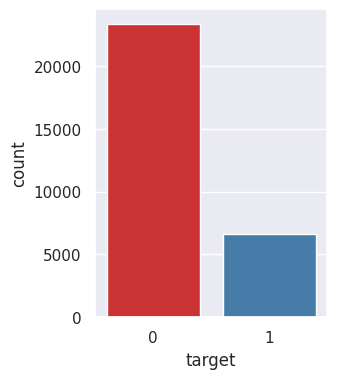

In [ ]:
f,ax = plt.subplots(figsize=(3,4))
ax = sns.countplot(x='target', data=df, palette='Set1')
plt.show()

Có thể thấy số lượng khách hàng không thực hiện các thanh toán mặc định lớn hơn rất nhiều so với những khách hàng thực hiện thanh toán (78% -
 22%). Có thể thấy dữ liệu này **không cân bằng**

##Data Cleaning

In [ ]:
df['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [ ]:
df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

Theo như mô tả của dữ liệu biến `EDUCATION` chỉ có các giá trị từ 1,2,3,4,5,6 nhưng đây xuất hiện cả 0 nữa => Chúng ta sẽ gộp chung những giá trị 0,5,6 thành 4 (others)

In [ ]:
fil = (df.EDUCATION == 5) | (df.EDUCATION == 6) | (df.EDUCATION == 0)
df.loc[fil, 'EDUCATION'] = 4
df.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [ ]:
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

* MARRIAGE: Tình trạng hôn nhân (1=married, 2=single, 3=others) => Gộp những giá trị bằng 0 thành 3

In [ ]:
df.loc[df.MARRIAGE == 0, 'MARRIAGE'] = 3
df.MARRIAGE.value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

In [ ]:
df['PAY_0'].value_counts()

 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_0, dtype: int64

Theo mô tả của bộ dữ liệu giá trị của `PAY_n` nếu có giá trị -1 = thanh toán hợp lệ, 1 = thanh toán chậm 1 tháng, 2 = thanh toán chậm 2 tháng, ... 8 = thanh toán chậm 8 tháng, 9 = thanh toán chậm 9 tháng hoặc nhiều hơn. Vậy những giá trị 0, -2 khả năng cao cũng là những thanh toán hợp lệ nên chúng ta sẽ gom lại thành 0 để thể hiện những thanh toán hợp lệ của KH

In [ ]:
fil = (df.PAY_0 == -2) | (df.PAY_0 == -1) | (df.PAY_0 == 0)
df.loc[fil, 'PAY_0'] = 0
fil = (df.PAY_2 == -2) | (df.PAY_2 == -1) | (df.PAY_2 == 0)
df.loc[fil, 'PAY_2'] = 0
fil = (df.PAY_3 == -2) | (df.PAY_3 == -1) | (df.PAY_3 == 0)
df.loc[fil, 'PAY_3'] = 0
fil = (df.PAY_4 == -2) | (df.PAY_4 == -1) | (df.PAY_4 == 0)
df.loc[fil, 'PAY_4'] = 0
fil = (df.PAY_5 == -2) | (df.PAY_5 == -1) | (df.PAY_5 == 0)
df.loc[fil, 'PAY_5'] = 0
fil = (df.PAY_6 == -2) | (df.PAY_6 == -1) | (df.PAY_6 == 0)
df.loc[fil, 'PAY_6'] = 0
late = df[['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]

In [ ]:
df['PAY_0'].value_counts()

0    23182
1     3688
2     2667
3      322
4       76
5       26
8       19
6       11
7        9
Name: PAY_0, dtype: int64

In [ ]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.842267,1.557267,35.485500,0.356767,0.320033,0.304067,0.258767,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.744494,0.521405,9.217904,0.760594,0.801727,0.790589,0.761113,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,1.000000,1.000000,21.000000,0.000000,0.000000,0.000000,0.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [ ]:
unused_feat = ['ID', 'target']

In [ ]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,1,20000.0,2,2,1,24,2,2,0,0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,0,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,0,0,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


##Spliting the Data

In [ ]:
def data_split(df, start, end, date_col):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df[date_col] >= start) & (df[date_col] < end)]
    data = data.reset_index(drop=True)
    return data

In [ ]:
df_train = data_split(df, start = 0, end=22500, date_col='ID')
df_test = data_split(df, start = 22500, end=172792, date_col='ID')

### Information Value

Tính Information Value (IV) của từng biến. IV dùng để đo độ tương quan giữa biến độc lập và biến dự đoán (ở dạng binary)

In [ ]:
def output_iv_importance(train_selected, label_col):
    feat_import_iv = toad.quality(train_selected, label_col,iv_only=True)
    feat_import_iv=feat_import_iv['iv']
    feat_import_iv = feat_import_iv.reset_index()
    feat_import_iv.columns = ['feature', 'iv']
    return feat_import_iv

df_iv = output_iv_importance(df_train, 'target')

In [ ]:
df_iv.head(30)

,feature,iv
0,PAY_0,0.846792
1,PAY_2,0.532123
2,PAY_3,0.398299
3,PAY_4,0.345959
4,PAY_5,0.334070
5,PAY_6,0.278567
6,PAY_AMT1,0.189334
7,LIMIT_BAL,0.170973
8,PAY_AMT2,0.168256
9,PAY_AMT3,0.128827


Trong thực tế, các biến có IV nhỏ hơn 0.02 sẽ bị loại. Từ đó, 2 biến `SEX` và `MARRIAGE` sẽ bị loại.
Có thể thấy `PAY_0`có IV cao nhất. Điều này hợp lí vì biến thể hiện tình trạng thanh toán ở thời điểm gần với thời điểm cần dự đoán nhất

In [ ]:
df_train = df_train.drop(['SEX', 'MARRIAGE'], axis=1)

## Feature Binning

In [ ]:
df_train.target.value_counts()

0    17411
1     5088
Name: target, dtype: int64

In [ ]:
df_train.shape

(22499, 23)

In [ ]:
combiner = toad.transform.Combiner()
# use the filtered features for training
# Use the stable chi-square binning,
# specifying that each bin has at least 5% data to ensure stability
# empty values will be automatically assigned to the best bin
combiner.fit(X = df_train,
             y = df_train.target,
             method='chi',
             min_samples = 0.05,
             exclude = unused_feat)

In [ ]:
filename = 'CreditScore_save1_combiner.pkl'
pickle.dump(combiner, open(filename, 'wb'))

In [ ]:
bins = combiner.export()
bins

{'LIMIT_BAL': [50000.0,
  60000.0,
  80000.0,
  110000.0,
  150000.0,
  230000.0,
  370000.0],
 'EDUCATION': [2],
 'AGE': [26, 29, 34, 46],
 'PAY_0': [1, 2],
 'PAY_2': [2],
 'PAY_3': [2],
 'PAY_4': [1],
 'PAY_5': [2],
 'PAY_6': [2],
 'BILL_AMT1': [2501.0],
 'BILL_AMT2': [2400.0, 8287.0, 35213.0],
 'BILL_AMT3': [2400.0, 7458.0, 81890.0],
 'BILL_AMT4': [2501.0],
 'BILL_AMT5': [2395.0, 8110.0, 35288.0],
 'BILL_AMT6': [19195.0, 50442.0],
 'PAY_AMT1': [6.0, 4902.0],
 'PAY_AMT2': [92.0, 1603.0, 4520.0, 15002.0],
 'PAY_AMT3': [1.0, 2921.0],
 'PAY_AMT4': [1.0, 1506.0, 3946.0],
 'PAY_AMT5': [1.0, 1880.0, 10000.0],
 'PAY_AMT6': [28.0, 480.0, 926.0, 1078.0, 1501.0, 4060.0, 9567.0]}

In [ ]:
df_train_bin = combiner.transform(df_train)
df_test_bin = combiner.transform(df_test[df_train_bin.columns])

In [ ]:
df_train_bin.head()

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,1,0,1,0,2,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,2,4,1,1,0,1,0,0,0,1,...,1,1,0,0,1,1,1,0,5,1
2,3,3,1,3,0,0,0,0,0,0,...,1,2,0,1,1,1,1,1,6,0
3,4,1,1,3,0,0,0,0,0,0,...,1,2,1,1,2,1,1,1,3,0
4,5,1,1,4,0,0,0,0,0,0,...,1,2,0,1,4,2,3,1,2,0


In [ ]:
df_test_bin.head()

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,22500,7,1,3,0,0,0,0,0,0,...,1,3,2,2,2,2,3,2,6,0
1,22501,5,1,2,0,0,0,0,0,0,...,1,0,0,0,1,2,2,2,5,0
2,22502,6,0,2,0,0,0,0,0,0,...,1,3,1,1,2,1,2,2,5,0
3,22503,1,1,3,0,0,1,1,1,0,...,1,2,1,1,2,0,0,1,2,1
4,22504,6,1,2,0,0,0,0,0,0,...,1,3,2,2,3,2,3,2,6,1


In [ ]:
features_list = [feat for feat in df_train_bin.columns if feat not in unused_feat]
len(features_list)

21

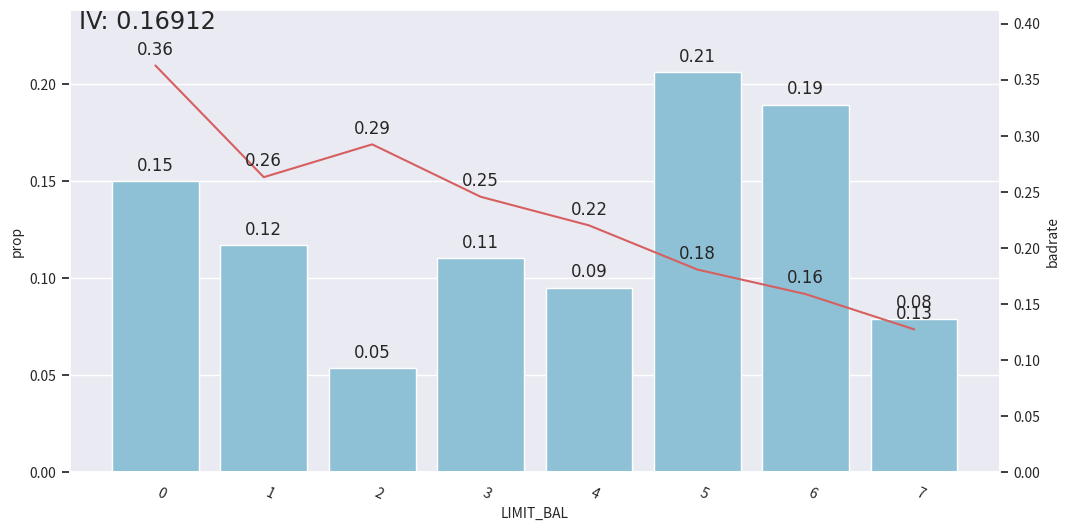

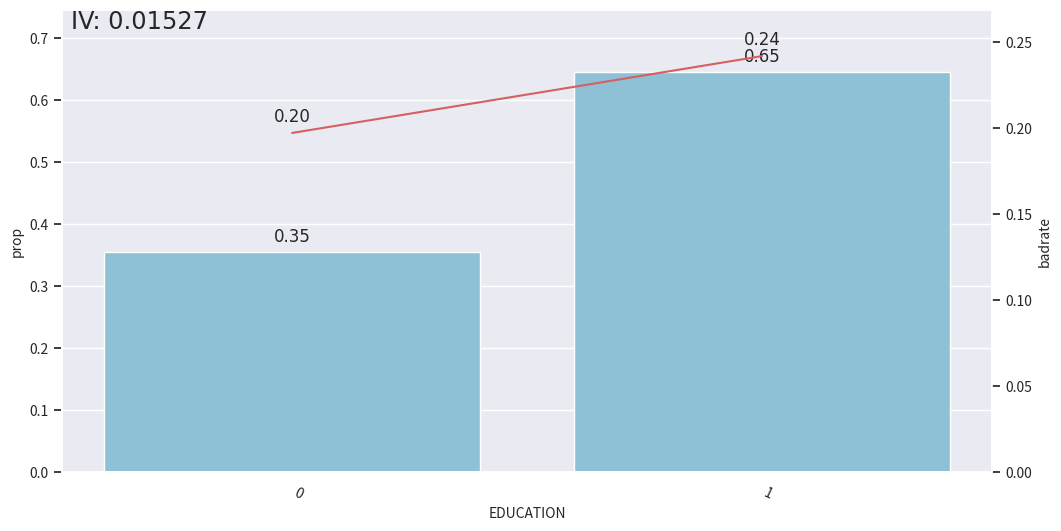

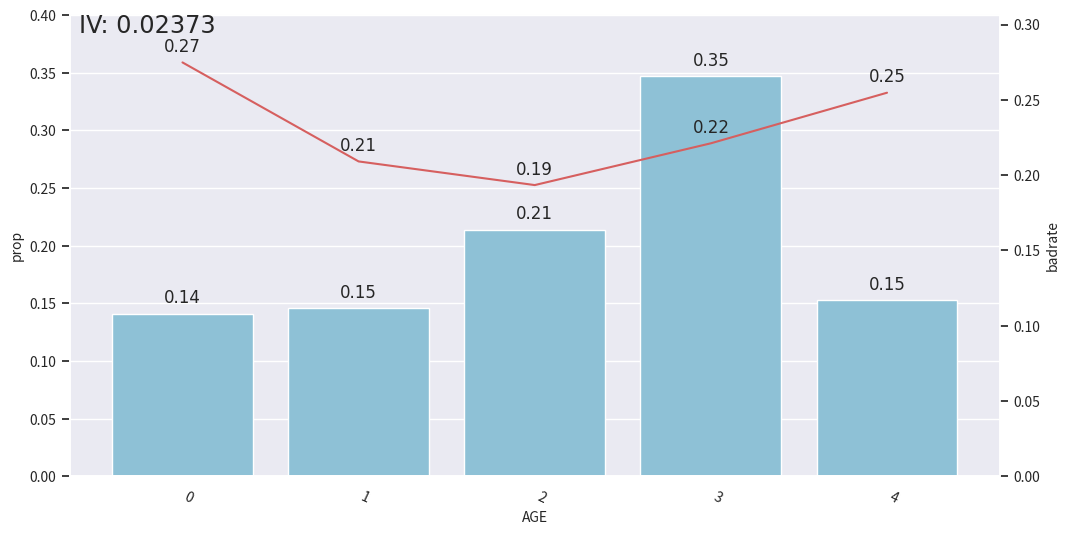

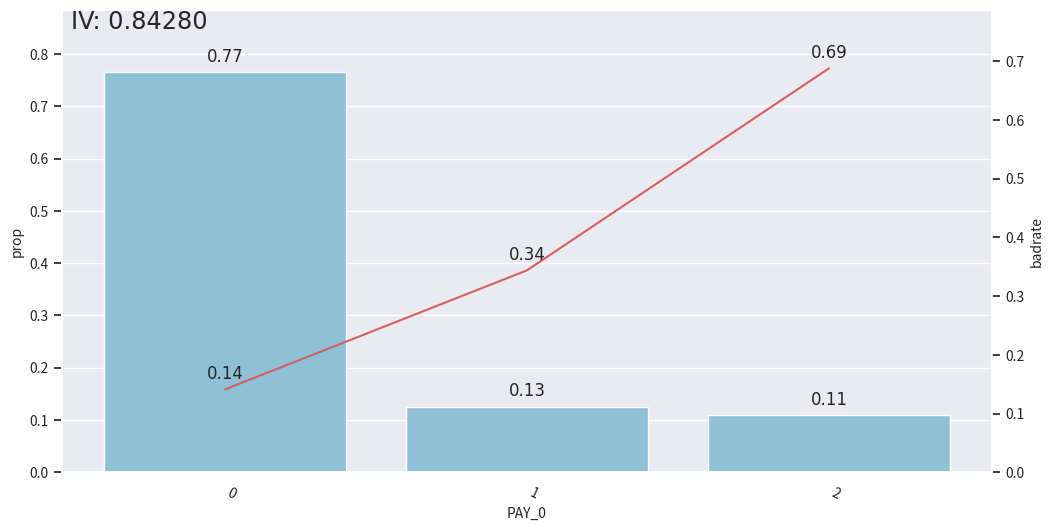

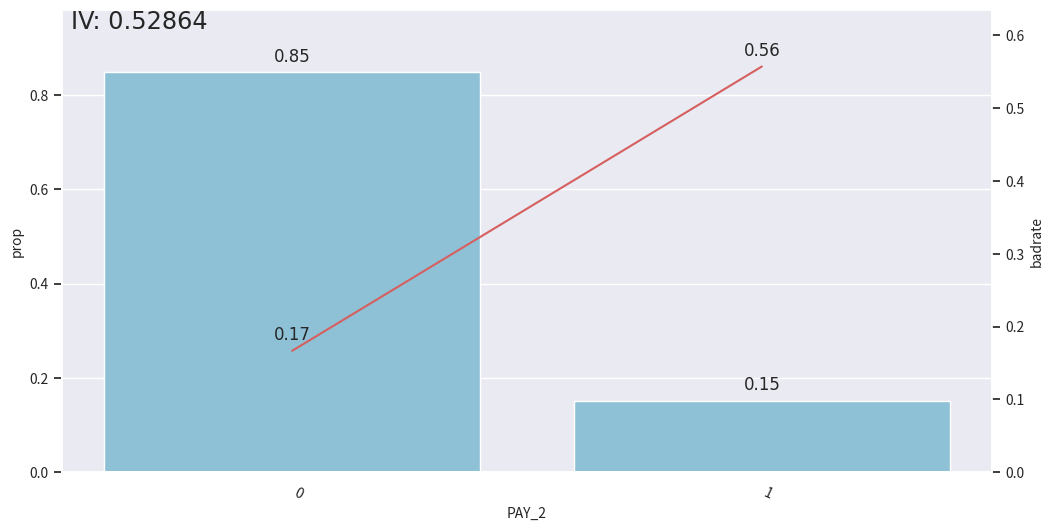

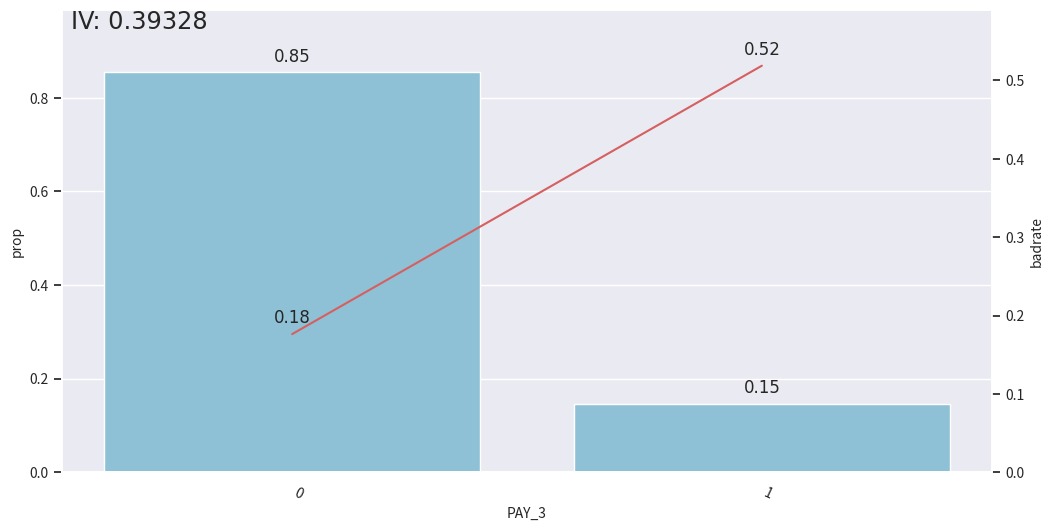

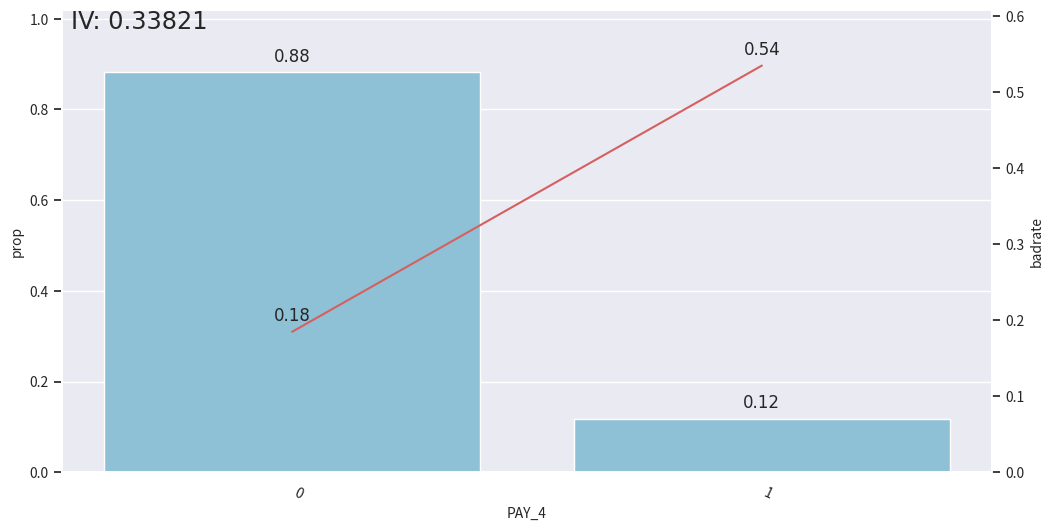

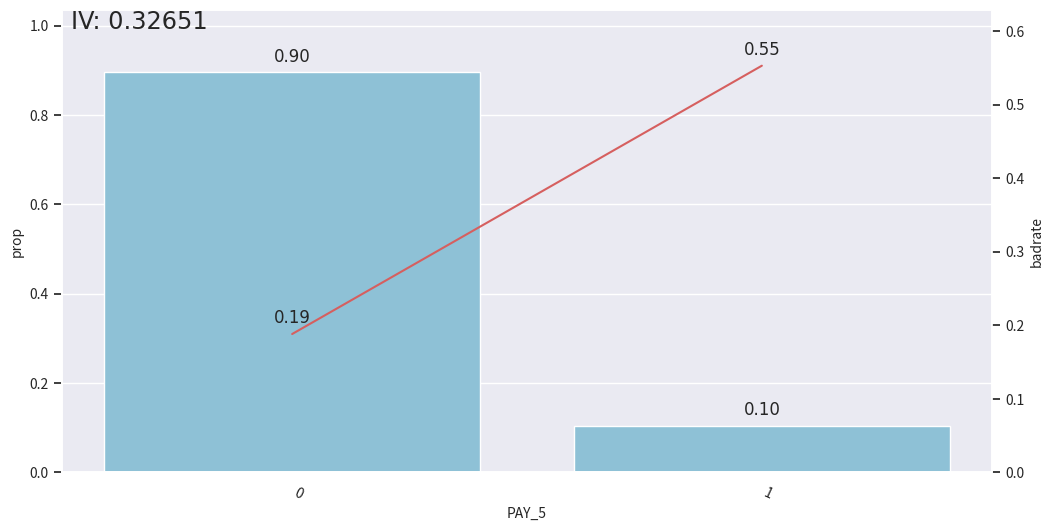

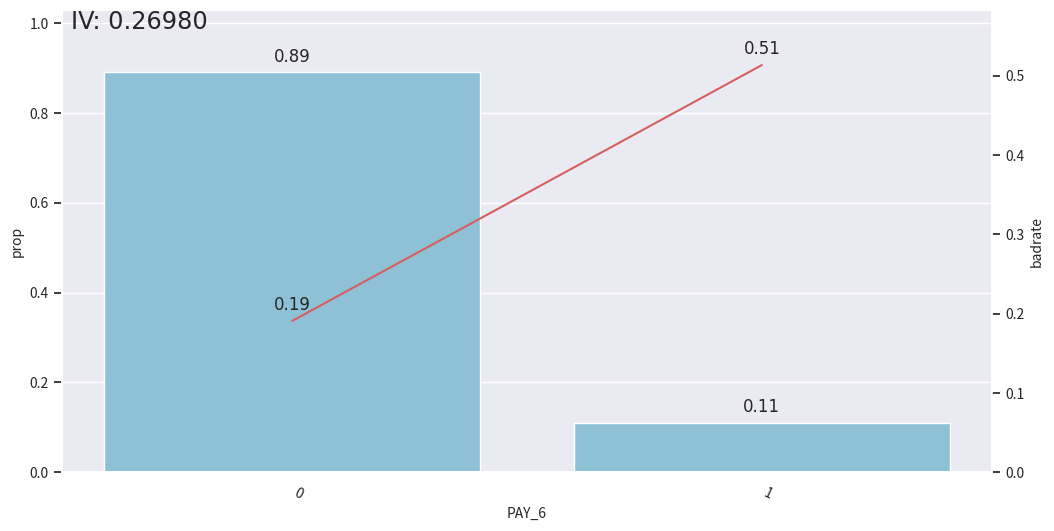

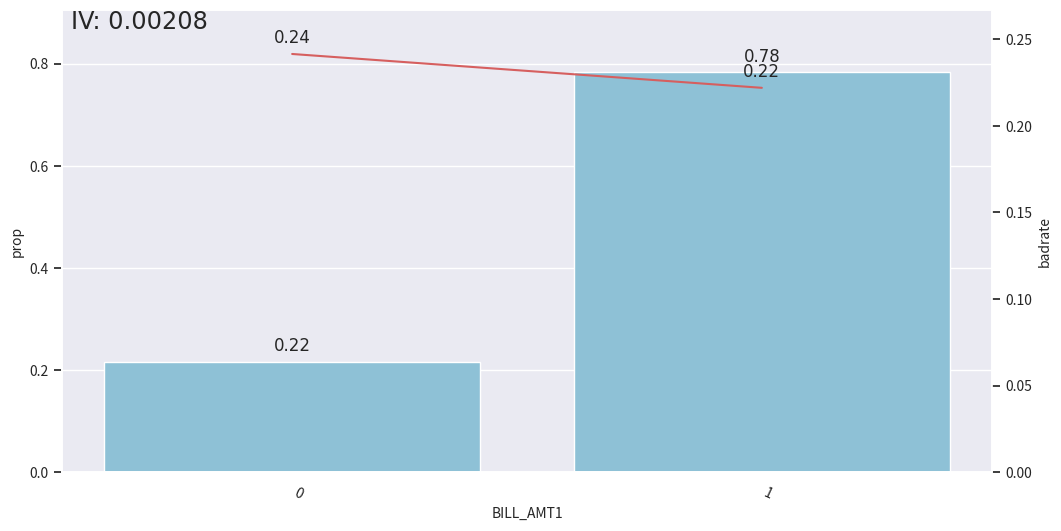

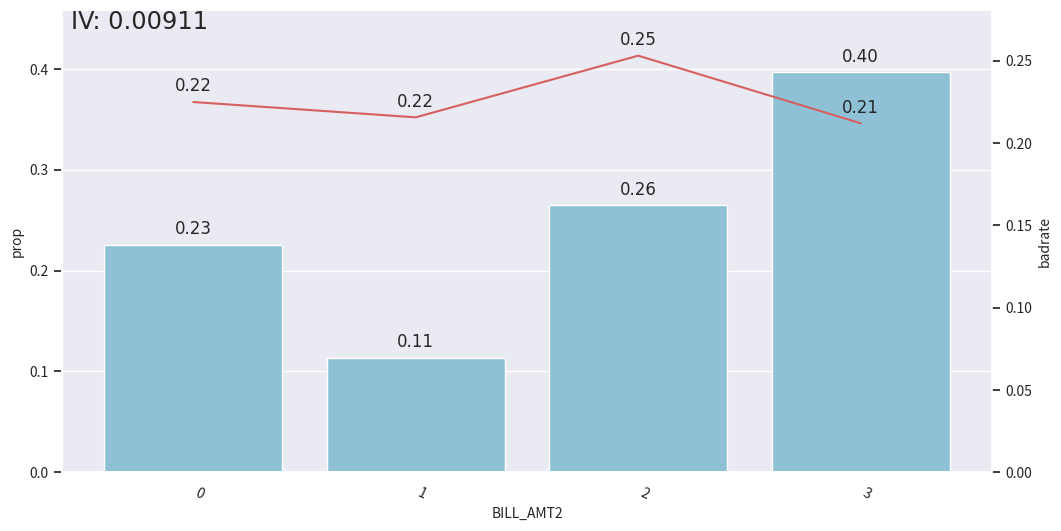

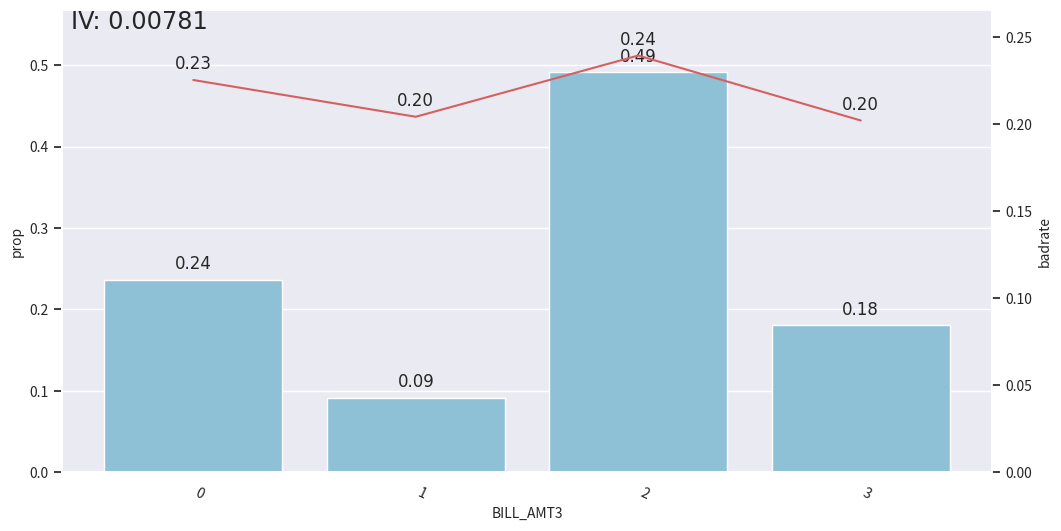

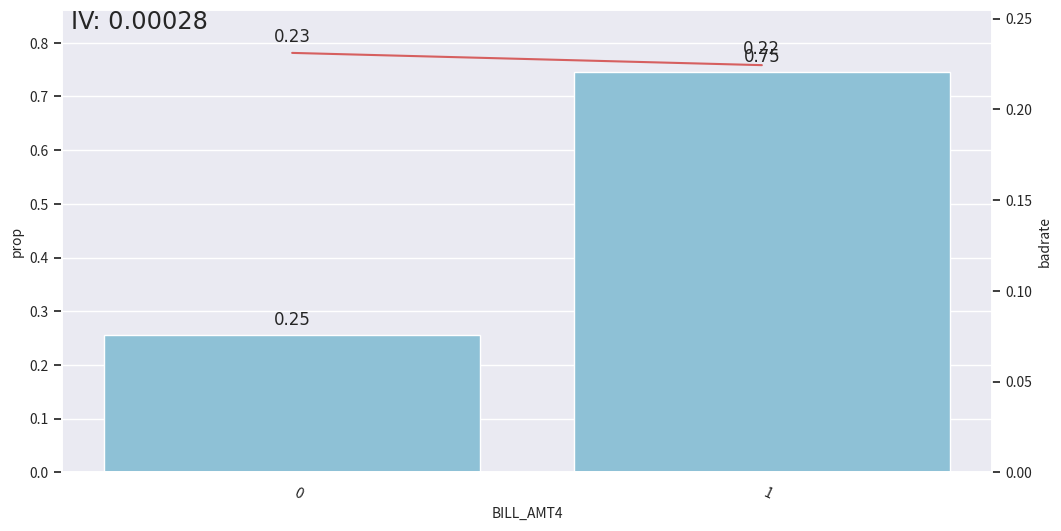

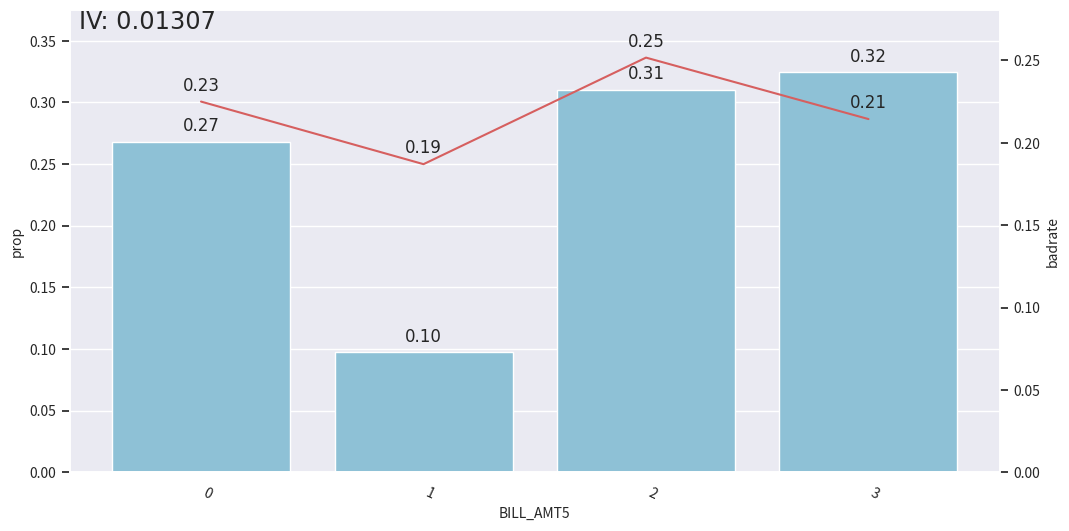

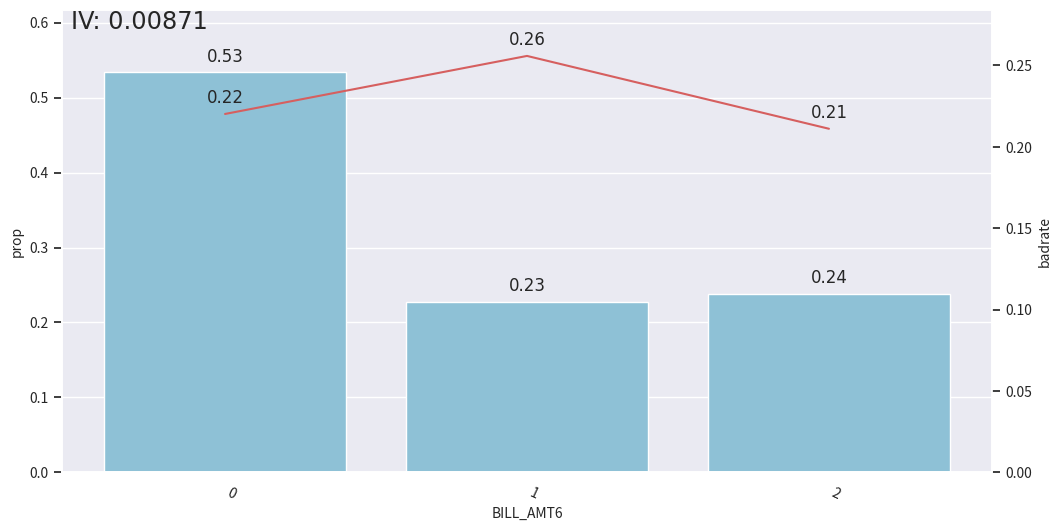

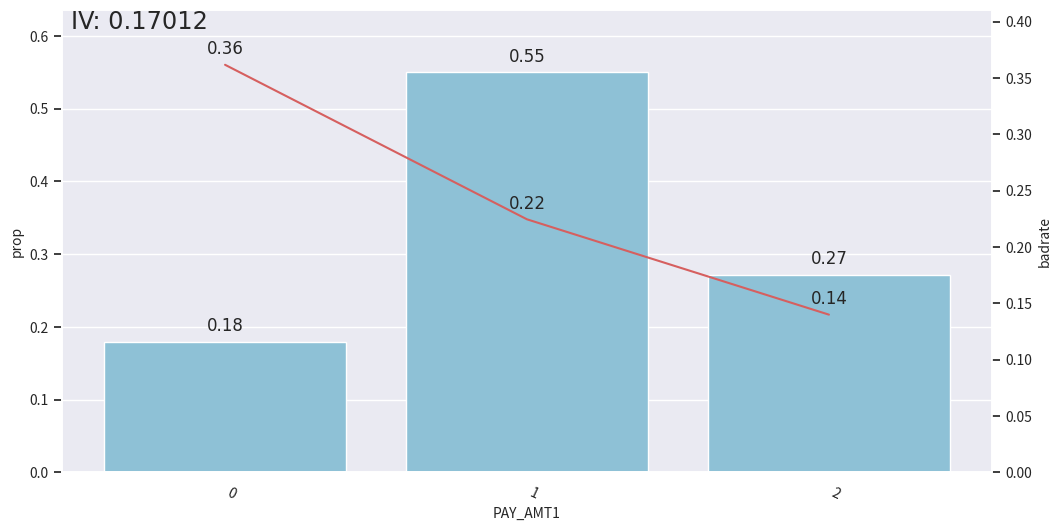

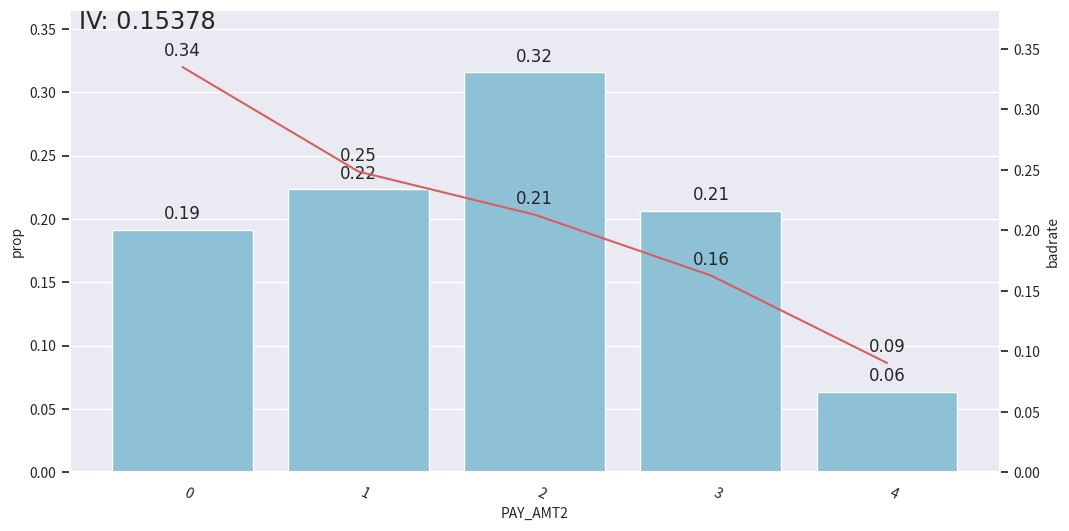

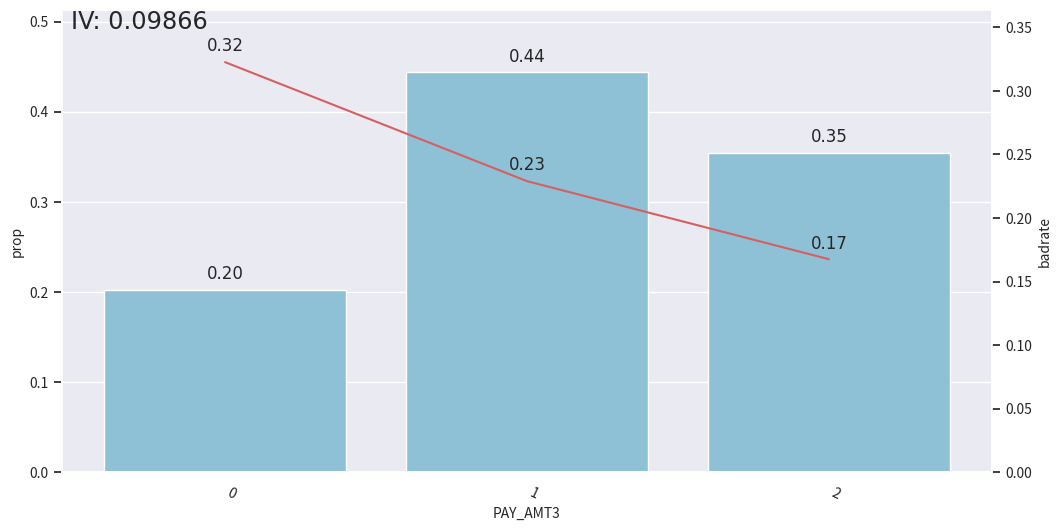

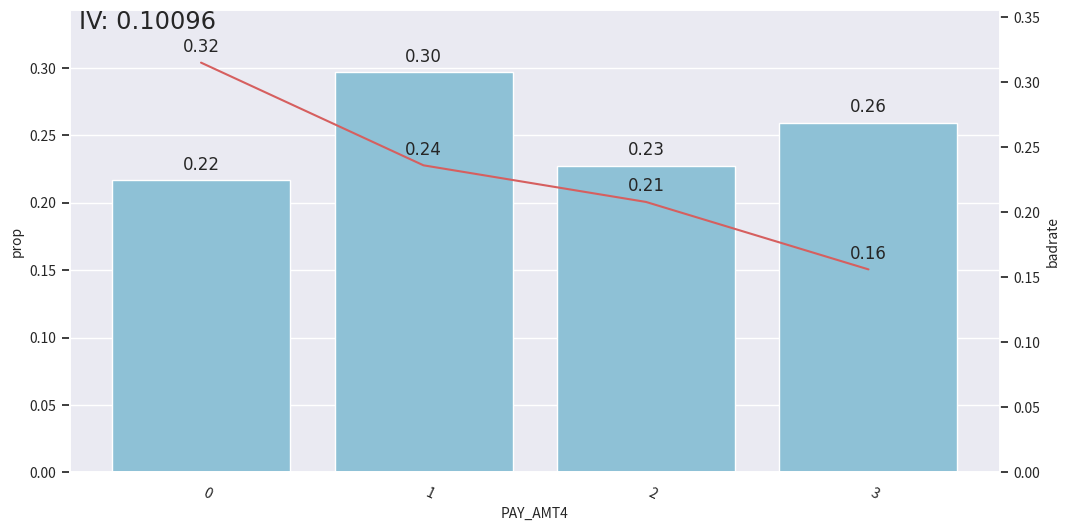

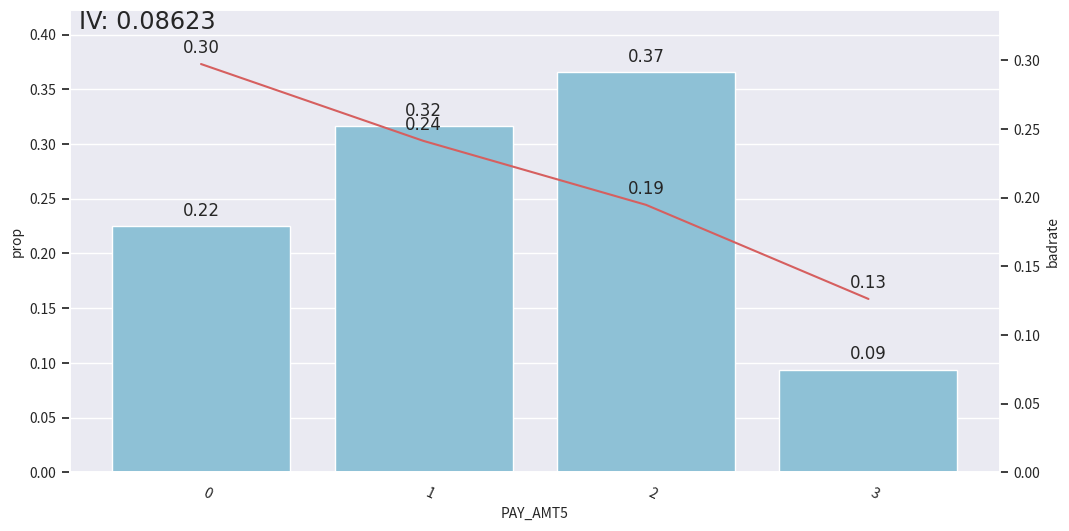

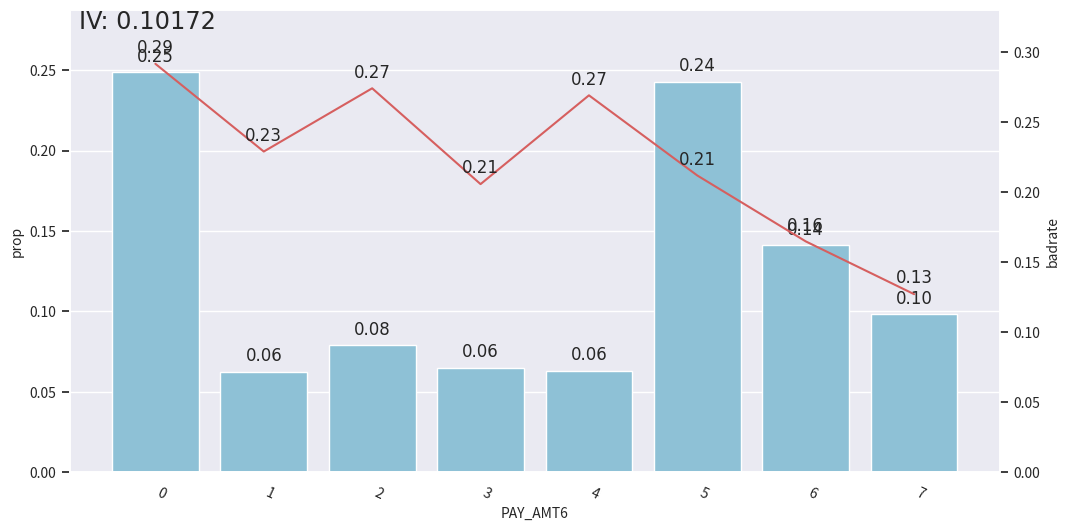

In [ ]:
for feat in features_list:
    bin_plot(df_train_bin,x = feat, target = 'target')

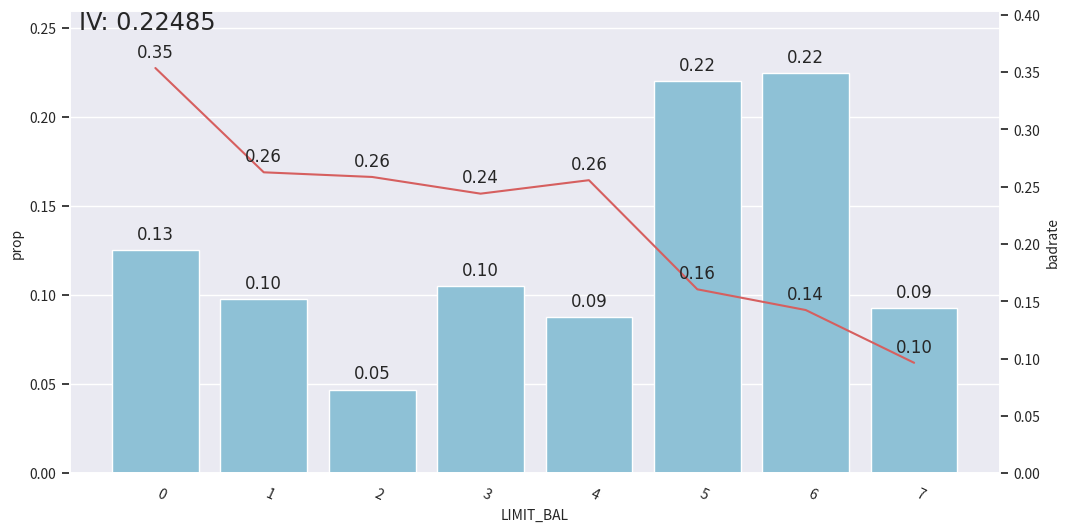

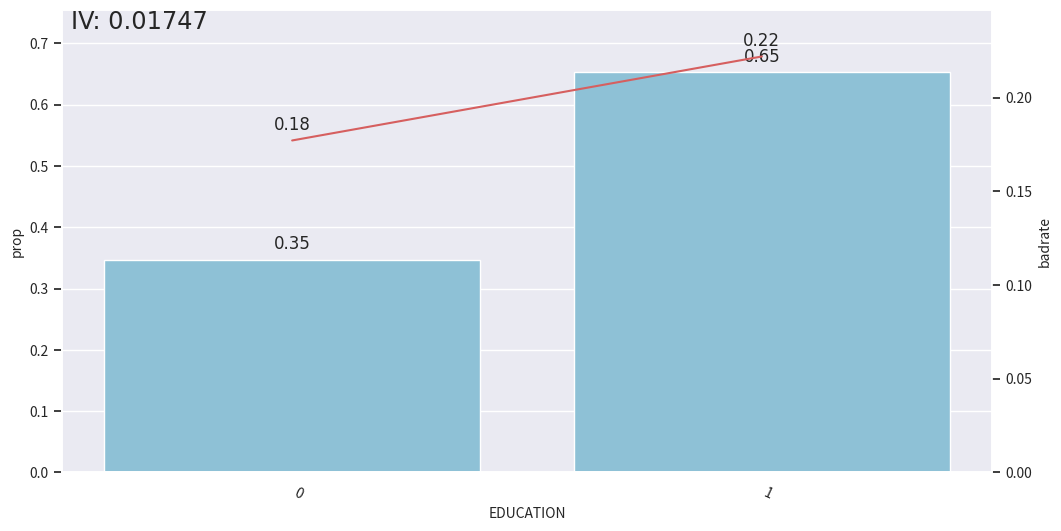

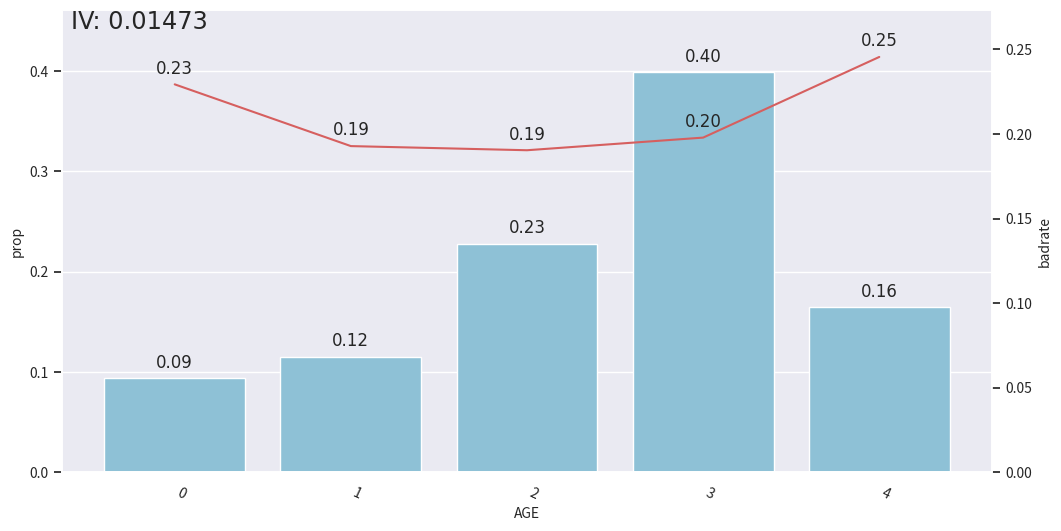

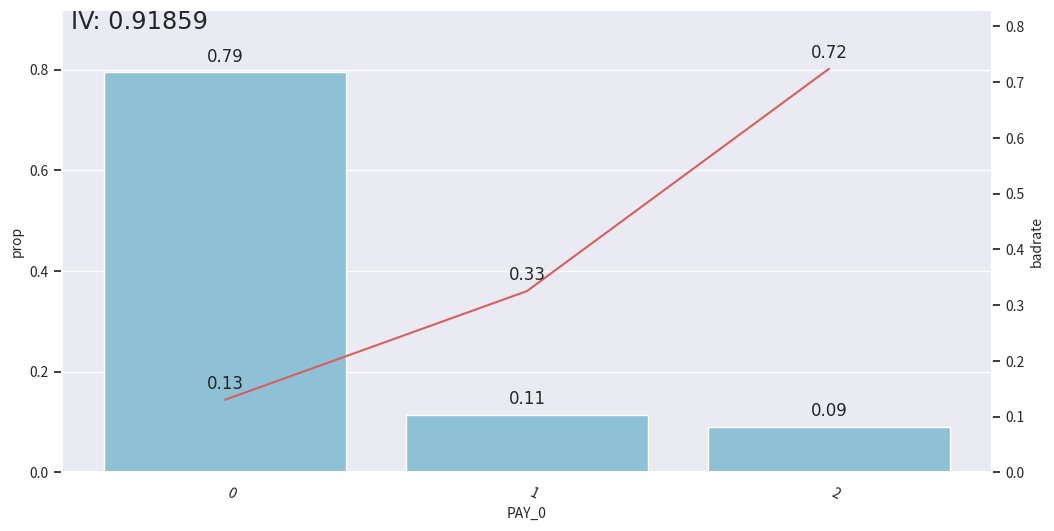

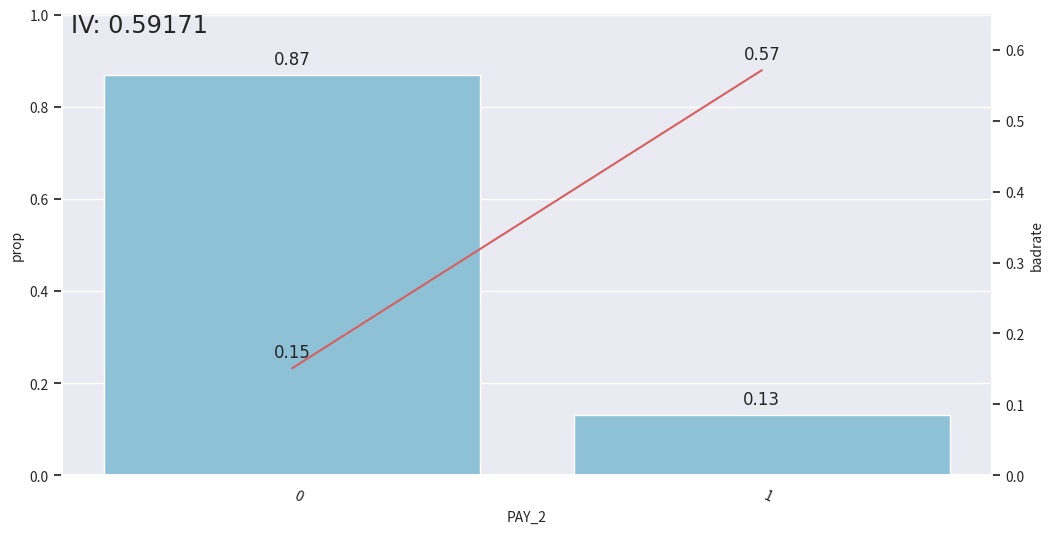

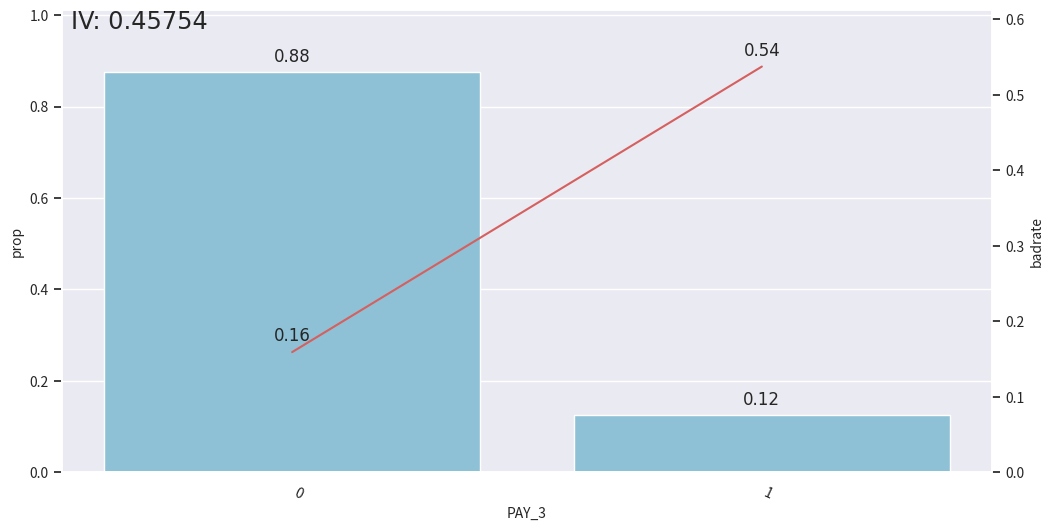

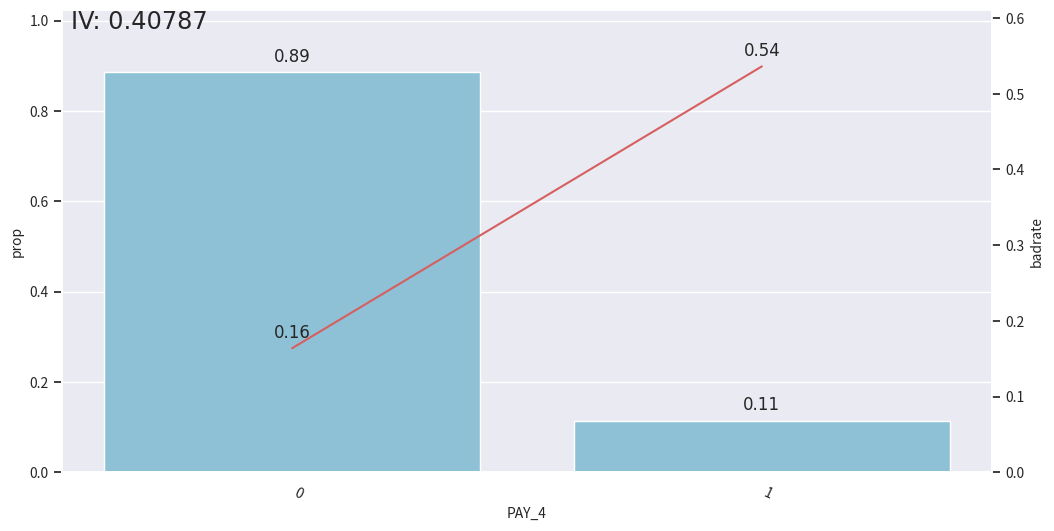

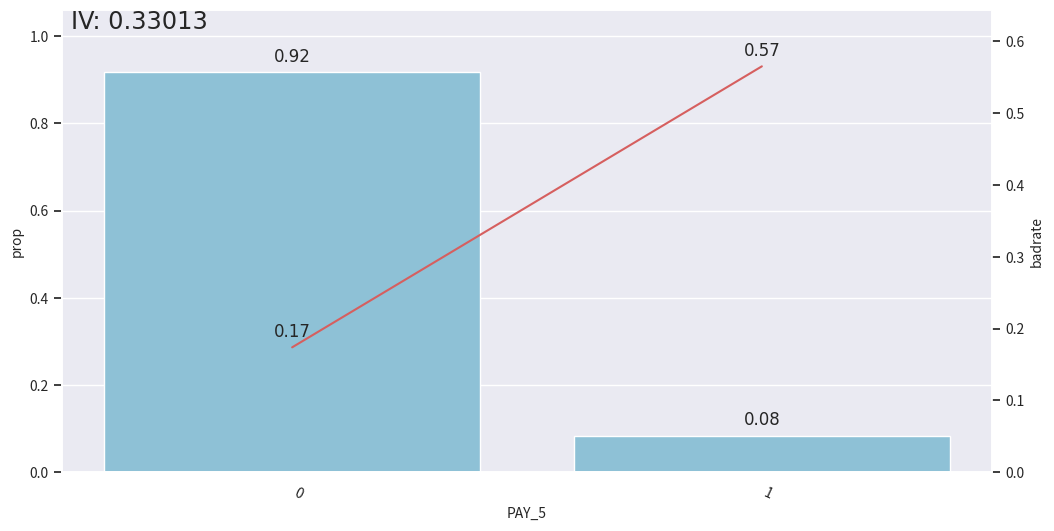

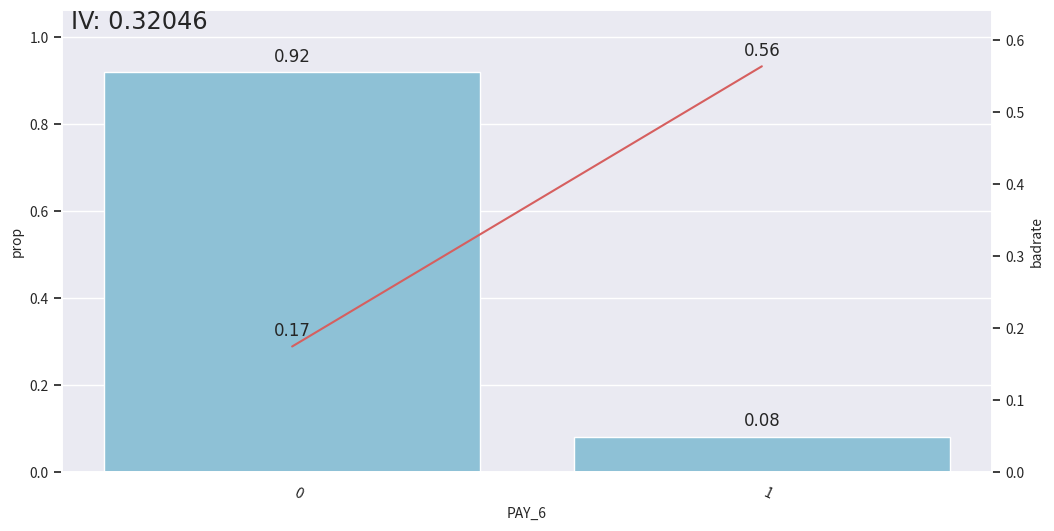

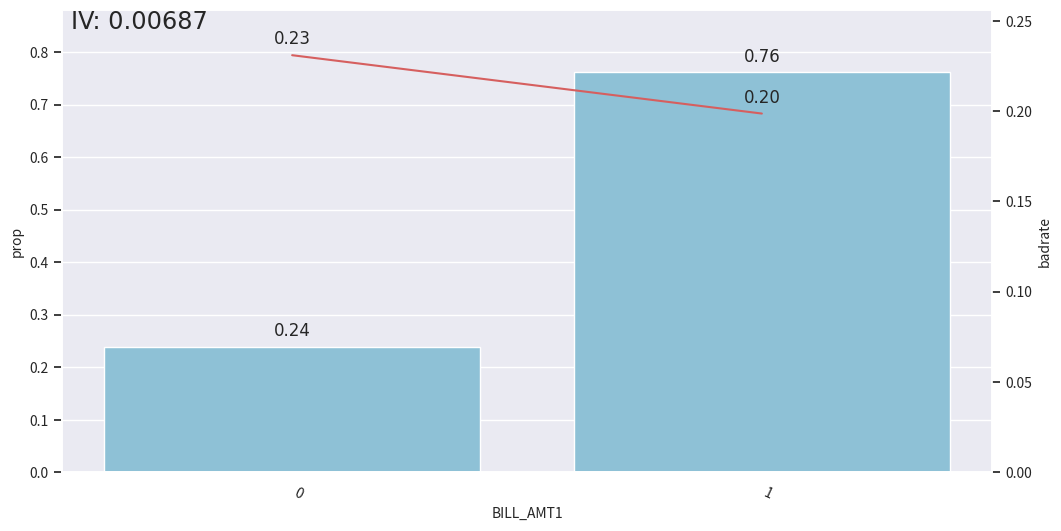

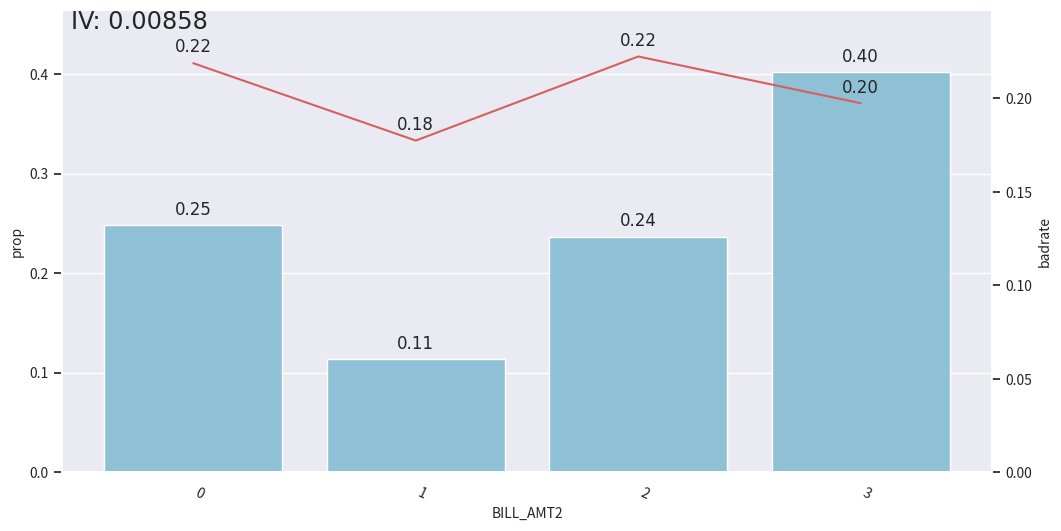

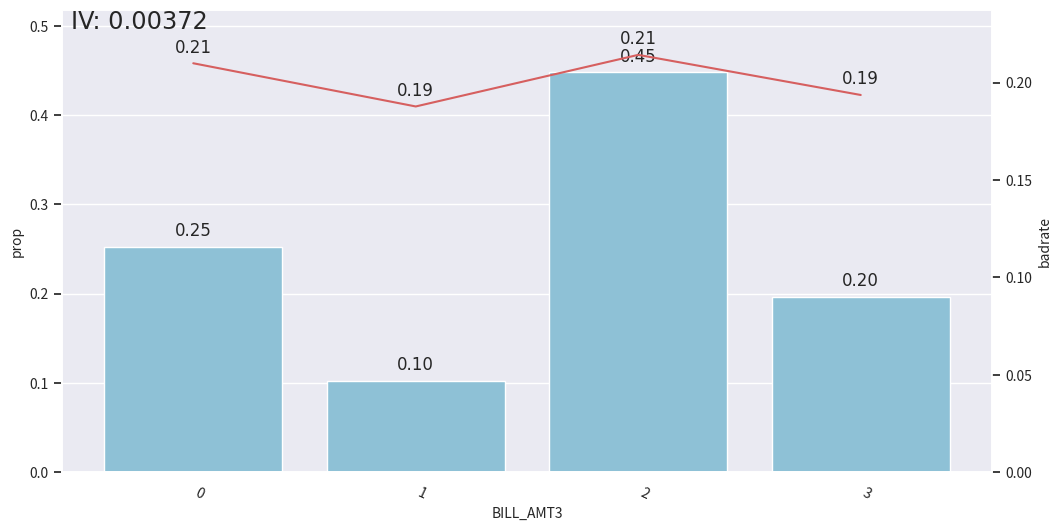

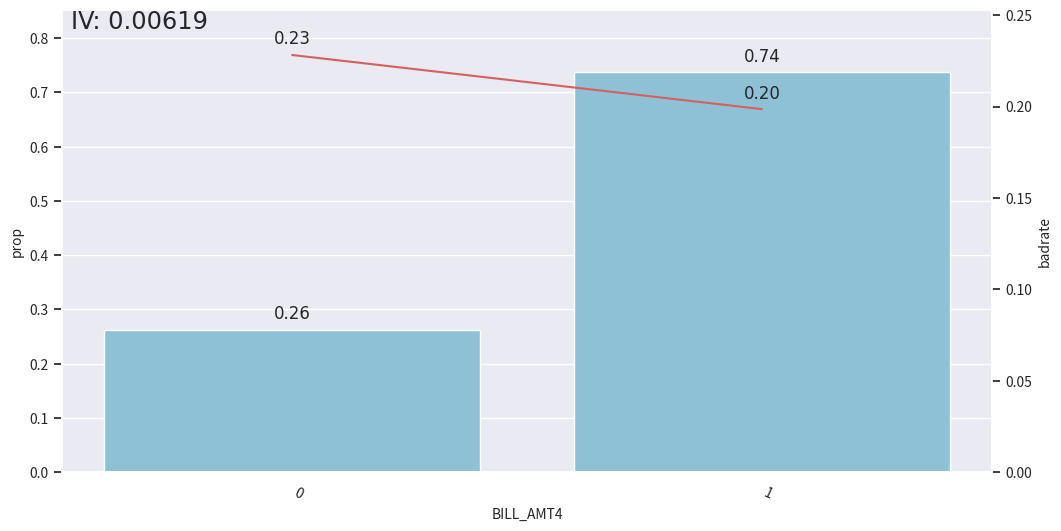

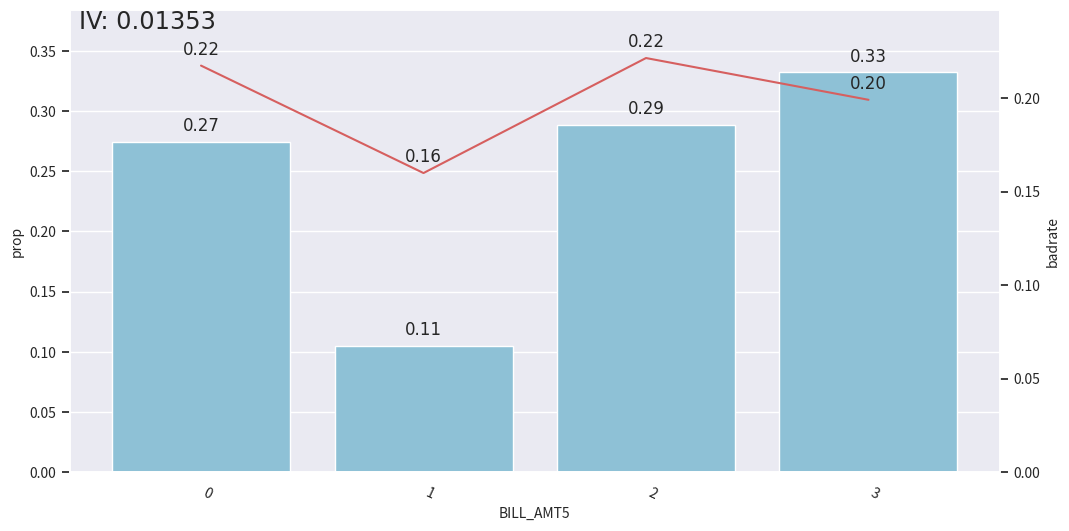

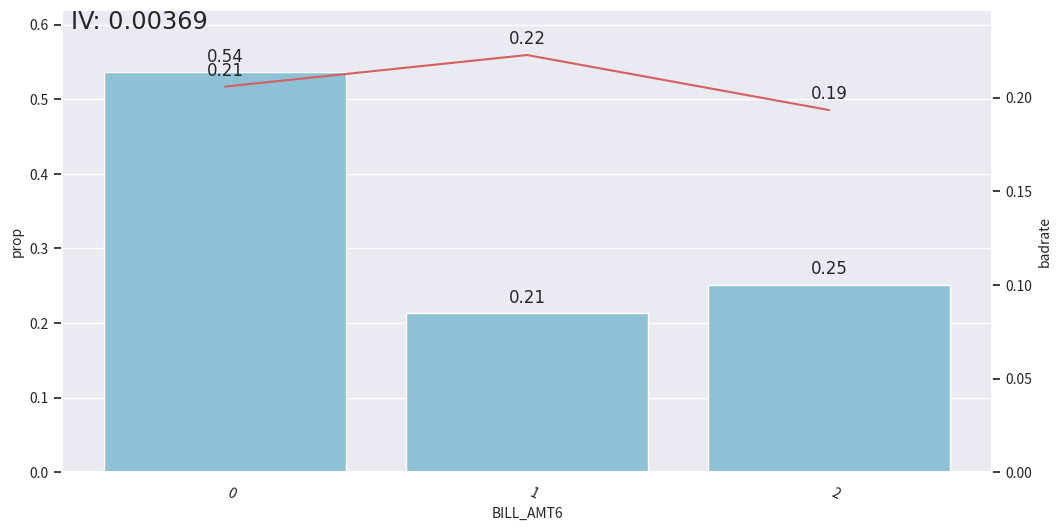

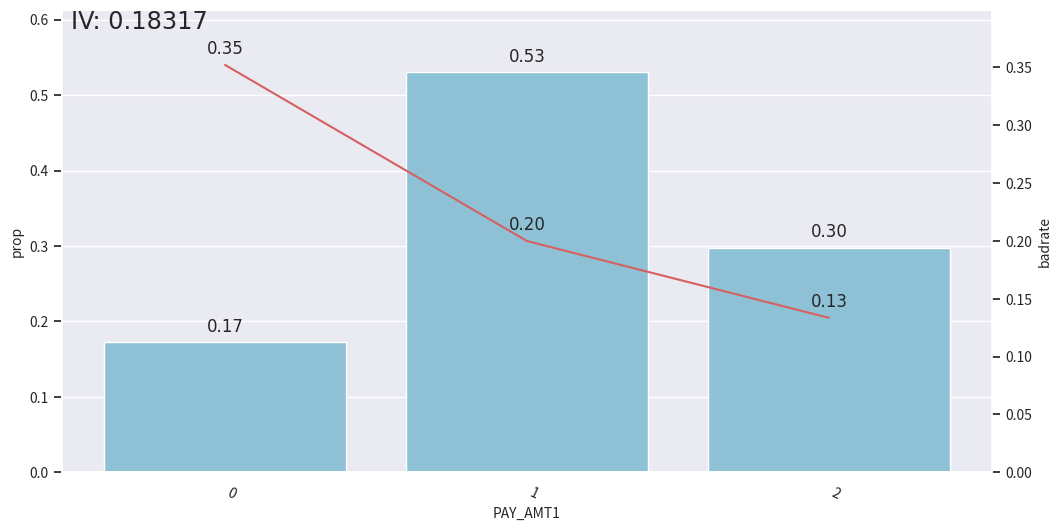

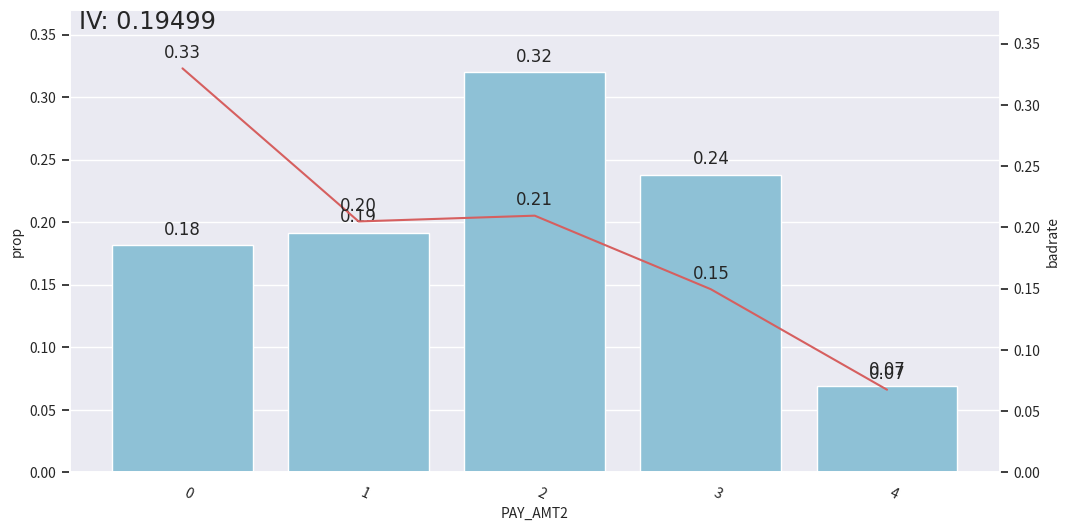

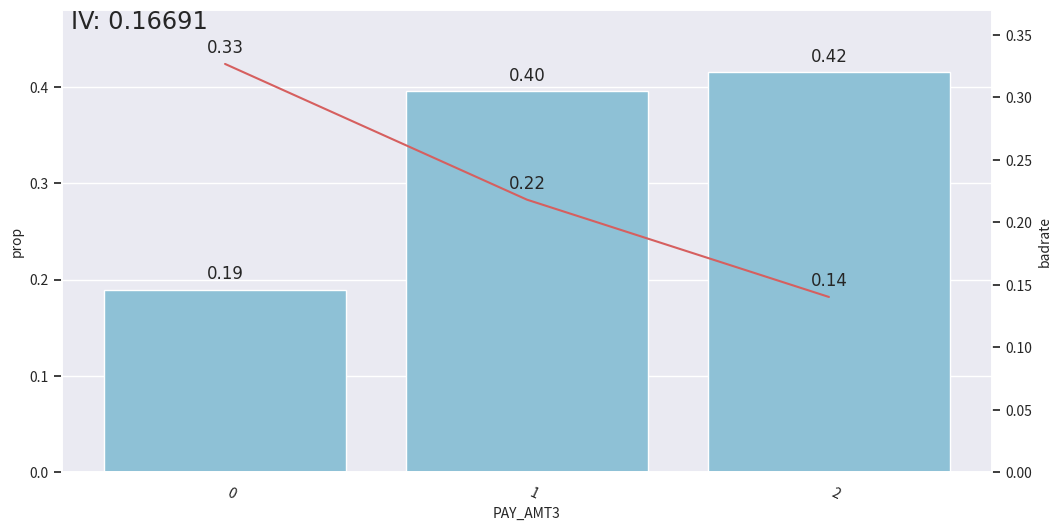

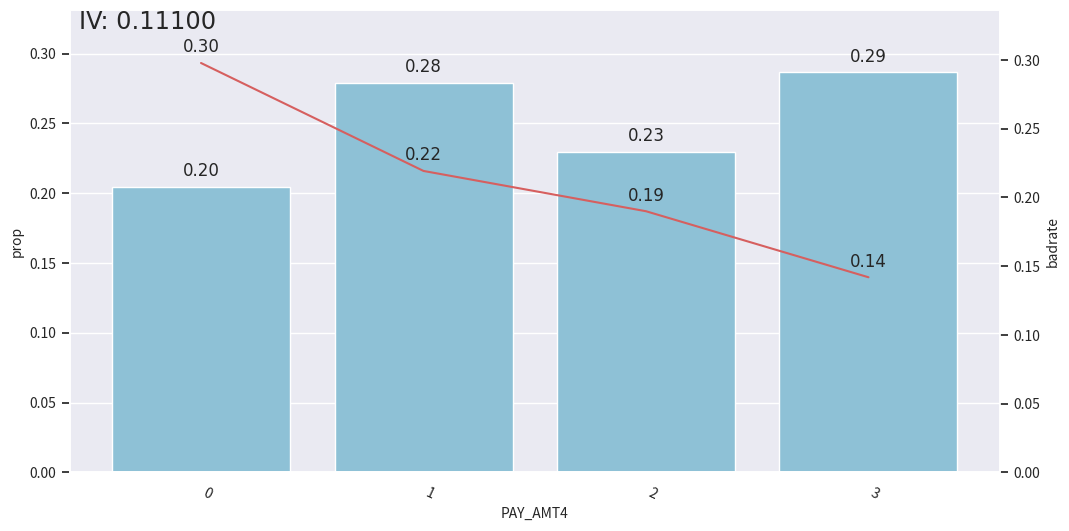

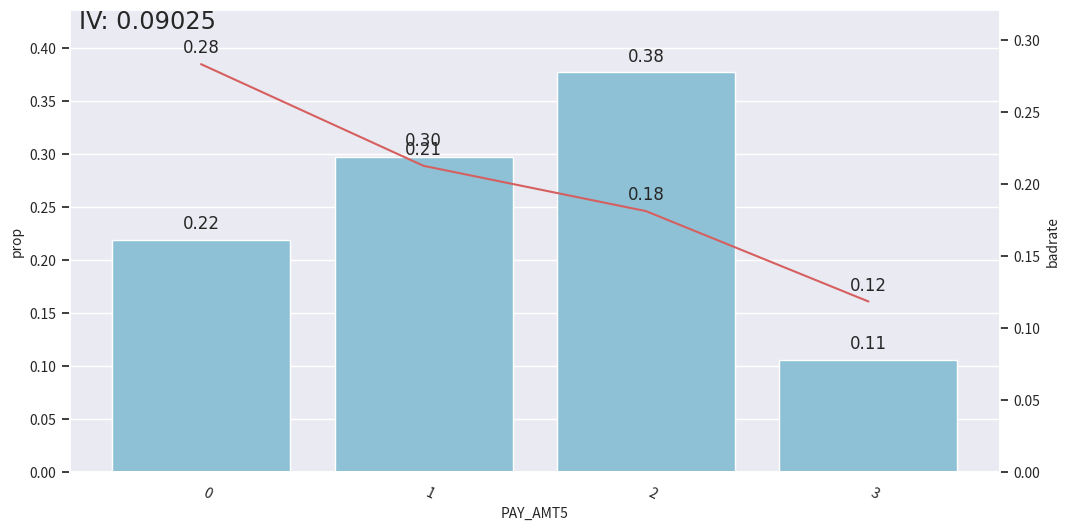

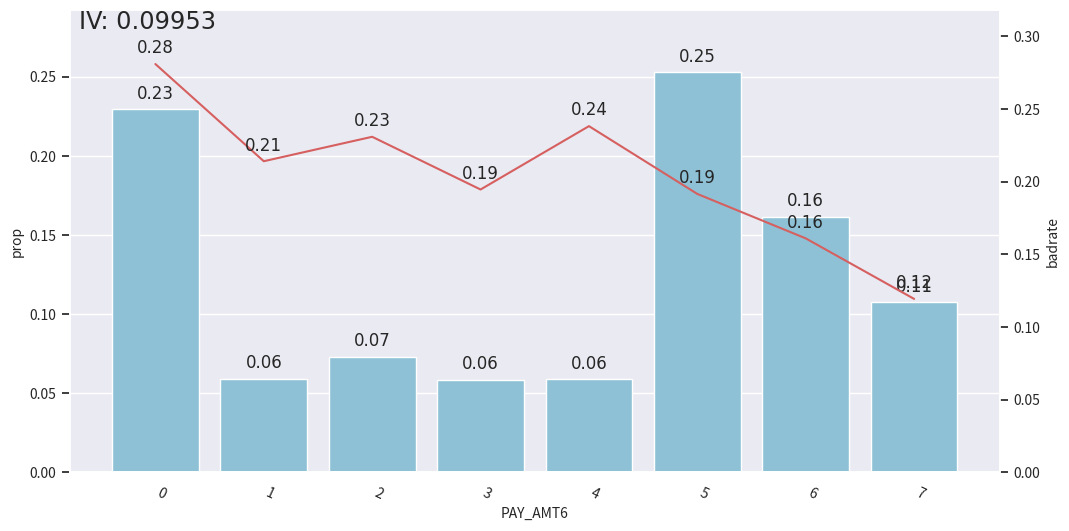

In [ ]:
for feat in features_list:
    bin_plot(df_test_bin,x = feat, target = 'target')

Có thể thấy các bin đều thỏa mãn yêu cầu **sô lượng quan sát mỗi bin phải trong khoảng 5 - 70%**

## Feature Encoding

Chọn WoE Encoding, do WoE là thước đo phản ánh độ lớn của tỷ lệ khách hàng tốt/khách hàng xấu trong mỗi nhóm của một biến hay khả năng phân biệt khách hàng tốt/khách hàng xấu của mỗi nhóm

In [ ]:
t = toad.transform.WOETransformer()

df_train_woe = t.fit_transform(X = df_train_bin,
                            y= df_train_bin['target'],
                            exclude = unused_feat)

df_test_woe = t.transform(df_test_bin)

In [ ]:
df_train_woe.head()

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,1,0.666522,0.088429,0.260065,2.019269,1.459809,-0.311239,-0.253727,-0.232378,-0.215037,...,0.028510,-0.006521,-0.034304,0.662394,0.124160,0.488183,0.454327,0.370272,0.343887,1
1,2,-0.034630,0.088429,-0.100163,-0.575364,1.459809,-0.311239,-0.253727,-0.232378,1.282840,...,-0.009858,-0.239312,-0.034304,0.662394,0.124160,0.016060,0.056501,0.370272,-0.082401,1
2,3,0.108342,0.088429,-0.028816,-0.575364,-0.378340,-0.311239,-0.253727,-0.232378,-0.215037,...,-0.009858,0.140562,-0.034304,-0.009085,0.124160,0.016060,0.056501,0.084926,-0.391360,0
3,4,0.200392,0.088429,-0.028816,-0.575364,-0.378340,-0.311239,-0.253727,-0.232378,-0.215037,...,-0.009858,0.140562,0.162615,-0.009085,-0.076846,0.016060,0.056501,0.084926,-0.119586,0
4,5,0.200392,0.088429,0.156679,-0.575364,-0.378340,-0.311239,-0.253727,-0.232378,-0.215037,...,-0.009858,0.140562,-0.034304,-0.009085,-1.078550,-0.372758,-0.457199,0.084926,0.257636,0


In [ ]:
final_df_woe = pd.concat([df_train_woe, df_test_woe])

In [ ]:
filename = 'CreditScore_save2_woe_transform.pkl'
pickle.dump(t, open(filename, 'wb'))

### Population Stability Index

In [ ]:
features_list = [feat for feat in df_train_woe.columns if feat not in unused_feat]
psi_df = toad.metrics.PSI(df_train_woe[features_list], df_test_woe[features_list]).sort_values(0)
psi_df = psi_df.reset_index()
psi_df = psi_df.rename(columns = {'index' : 'feature',0:'psi'})
psi_df

,feature,psi
0,PAY_4,0.000144
1,EDUCATION,0.000264
2,BILL_AMT4,0.000330
3,BILL_AMT6,0.001591
4,BILL_AMT5,0.002520
5,BILL_AMT1,0.002634
6,PAY_AMT5,0.003066
7,PAY_2,0.003356
8,PAY_AMT1,0.003402
9,PAY_3,0.003669


Việc tính PSI của các biến độc lập trong tập train và test để chắc chắn rằng không có sự dịch chuyển phân phối của các biến. Các biến của PSI > 0.25 sẽ bị loại.

In [ ]:
psi025 = list(psi_df[psi_df.psi < 0.25].feature)

In [ ]:
for i in unused_feat:
    if i in psi025:
        pass
    else:
       psi025.append(i)

In [ ]:
df_train_woe_psi = df_train_woe[psi025]
df_test_woe_psi = df_test_woe[psi025]

In [ ]:
final_df_woe = pd.concat([df_train_woe_psi, df_test_woe_psi])

In [ ]:
print(final_df_woe.shape)

(30000, 23)


In [ ]:
final_df_woe.to_csv('CreditScore_save3_final_data_woe.csv')

In [ ]:
df_iv = output_iv_importance(final_df_woe[features_list+['target']],'target')
iv_psi_df = df_iv.merge(psi_df, on = 'feature', how = 'left')
iv_psi_df.style.bar()

,feature,iv,psi
0,PAY_0,0.860976,0.005472
1,PAY_2,0.544104,0.003356
2,PAY_3,0.408793,0.003669
3,PAY_4,0.354314,0.000144
4,PAY_5,0.328299,0.005487
5,PAY_6,0.281568,0.009655
6,LIMIT_BAL,0.181621,0.018541
7,PAY_AMT1,0.173425,0.003402
8,PAY_AMT2,0.162703,0.010605
9,PAY_AMT3,0.114630,0.016165


##Baseline

### Helper function

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

In [ ]:
def plot_confusion_matrix(label, predictions):
    cf_matrix = confusion_matrix(label, predictions)
    labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    categories = ['Non default', 'Default']
    make_confusion_matrix(cf_matrix,
                      categories=categories,
                      group_names=labels,
                      cbar=False, sum_stats = False, count = True)

In [ ]:
def plot_roc_pre_recall_curve(labels, probs):
    from sklearn.metrics import precision_recall_curve
    # Get ROC curve FPR and TPR from true labels vs score values
    fpr, tpr, _ = roc_curve(labels, probs)

    # Calculate ROC Area Under the Curve (AUC) from FPR and TPR data points
    roc_auc = auc(fpr, tpr)

    # Calculate precision and recall from true labels vs score values
    precision, recall, _ = precision_recall_curve(labels, probs)

    plt.figure(figsize=(8, 3))

    plt.subplot(1,2,1)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.step(recall, precision, color='orange', where='post')
    # plt.fill_between(recall, precision, step='post', alpha=0.5, color='orange')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision Recall Curve')
    plt.grid(True)

    left  = 0.125  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.5   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots
    plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
    plt.show()

In [ ]:
def run_baseline_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)

    # y_pred = model.predict(X_test)

    pred_train = model.predict_proba(X_train)[:,1]
    print('train KS', KS(pred_train, y_train))
    print('train AUC', AUC(pred_train, y_train))

    pred_test = model.predict_proba(X_test)[:,1]
    print('Test KS',KS(pred_test, y_test))
    print('Test AUC',AUC(pred_test, y_test))

In [ ]:
def get_evaluation_score(model, test_df, label):

    predictions = model.predict(test_df)

    accuracy = accuracy_score(label, predictions)
    roc_auc = AUC(model.predict_proba(test_df)[:, 1], label)
    precision = precision_score(label, predictions)
    recall = recall_score(label, predictions)
    f1 = f1_score(label, predictions)

    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Precision  = {}".format(precision))
    print("Recall  = {}".format(recall))
    print("F1 Score  = {}".format(f1))

    print(classification_report(label, predictions))

    plot_confusion_matrix(label, predictions)

### Baseline LR model

In [ ]:
params_lr = {'penalty': 'l1', 'solver':'liblinear', 'class_weight': 'balanced'}

model_lr = LogisticRegression(**params_lr)
# model_lrsmt, accuracy_lrsmt, roc_auc_lrsmt,f1_score_lrsmt,coh_kap_lrsmt, tt_lrsmt = run_model(model_lrsmt, X_train_smote, y_train_smote, X_test, y_test)
run_baseline_model(model = model_lr, X_train = df_train_woe[features_list], y_train= df_train_woe['target'],
                     X_test = df_test_woe[features_list] , y_test = df_test_woe['target'])

train KS 0.4083612990089039
train AUC 0.7688088414791632
Test KS 0.4300239906832635
Test AUC 0.7859483156387395


#Modeling

In [ ]:
def run_model(model, df_train, df_test):

    X_train = df_train[features_list]
    y_train = df_train['target']

    X_test  = df_test[features_list]
    y_test  = df_test['target']

    model.fit(X_train, y_train)

    get_evaluation_score(model = model, test_df = X_test, label = y_test)


**Note**: Do dữ liệu không cân bằng nên sử dụng **'class_weight': 'balanced'** để tăng khả năng đoán đúng các nhãn default

##Logistic Regression

Accuracy = 0.7869617384348754
ROC Area under Curve = 0.7859492922813547
Precision  = 0.4860335195530726
Recall  = 0.562015503875969
F1 Score  = 0.5212702216896345
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      5953
           1       0.49      0.56      0.52      1548

    accuracy                           0.79      7501
   macro avg       0.68      0.70      0.69      7501
weighted avg       0.80      0.79      0.79      7501



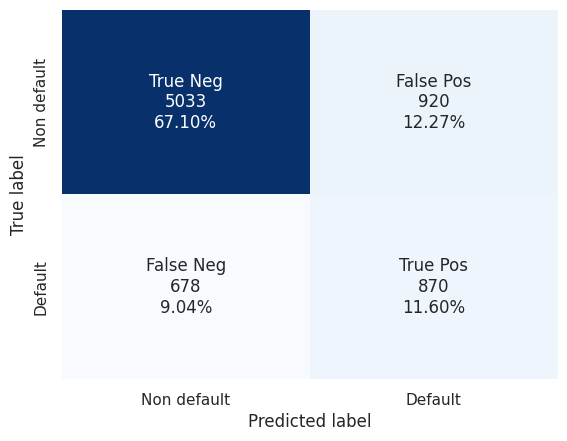

In [ ]:
from sklearn.linear_model import LogisticRegression

params_lr = {'penalty': 'l1', 'solver':'liblinear', 'class_weight': 'balanced'}

model_lr = LogisticRegression(**params_lr)
run_model(model = model_lr, df_train = df_train_woe, df_test = df_test_woe)

##Random Forest

Accuracy = 0.814424743367551
ROC Area under Curve = 0.763190155355626
Precision  = 0.5666666666666667
Recall  = 0.42829457364341084
F1 Score  = 0.4878587196467991
              precision    recall  f1-score   support

           0       0.86      0.91      0.89      5953
           1       0.57      0.43      0.49      1548

    accuracy                           0.81      7501
   macro avg       0.71      0.67      0.69      7501
weighted avg       0.80      0.81      0.80      7501



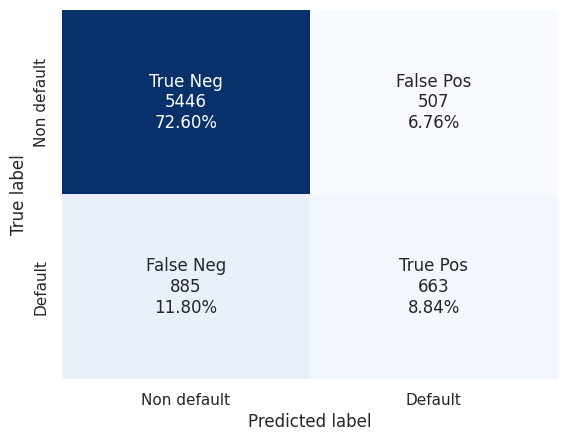

In [ ]:
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345,
             'class_weight': 'balanced'
             }

model_rf = RandomForestClassifier(**params_rf)
run_model(model = model_rf, df_train = df_train_woe, df_test = df_test_woe)

##AdaBoost

Accuracy = 0.7796293827489668
ROC Area under Curve = 0.7915509887746869
Precision  = 0.4739454094292804
Recall  = 0.6169250645994832
F1 Score  = 0.536065113668257
              precision    recall  f1-score   support

           0       0.89      0.82      0.86      5953
           1       0.47      0.62      0.54      1548

    accuracy                           0.78      7501
   macro avg       0.68      0.72      0.70      7501
weighted avg       0.81      0.78      0.79      7501



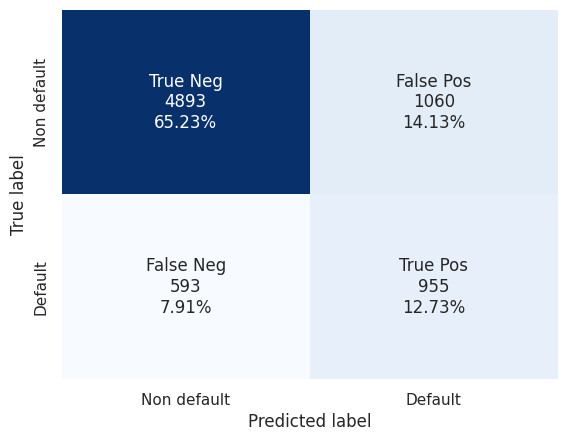

In [ ]:
model_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, class_weight = 'balanced'),
                                  n_estimators=50,
                                  algorithm="SAMME.R",
                                  learning_rate=0.5
                                  )
run_model(model = model_ada, df_train = df_train_woe, df_test = df_test_woe)

##CatBoost

Learning rate set to 0.5
0:	learn: 0.4895068	total: 97.7ms	remaining: 4.78s
1:	learn: 0.4396440	total: 181ms	remaining: 4.34s
2:	learn: 0.4220843	total: 248ms	remaining: 3.88s
3:	learn: 0.4143066	total: 291ms	remaining: 3.35s
4:	learn: 0.4042102	total: 351ms	remaining: 3.15s
5:	learn: 0.3968452	total: 382ms	remaining: 2.8s
6:	learn: 0.3901426	total: 434ms	remaining: 2.66s
7:	learn: 0.3848261	total: 490ms	remaining: 2.57s
8:	learn: 0.3785911	total: 557ms	remaining: 2.54s
9:	learn: 0.3704382	total: 619ms	remaining: 2.48s
10:	learn: 0.3665724	total: 669ms	remaining: 2.37s
11:	learn: 0.3625989	total: 705ms	remaining: 2.23s
12:	learn: 0.3578633	total: 760ms	remaining: 2.16s
13:	learn: 0.3541745	total: 814ms	remaining: 2.09s
14:	learn: 0.3498429	total: 854ms	remaining: 1.99s
15:	learn: 0.3446514	total: 900ms	remaining: 1.91s
16:	learn: 0.3399813	total: 931ms	remaining: 1.81s
17:	learn: 0.3399761	total: 937ms	remaining: 1.67s
18:	learn: 0.3340970	total: 995ms	remaining: 1.62s
19:	learn: 0.330

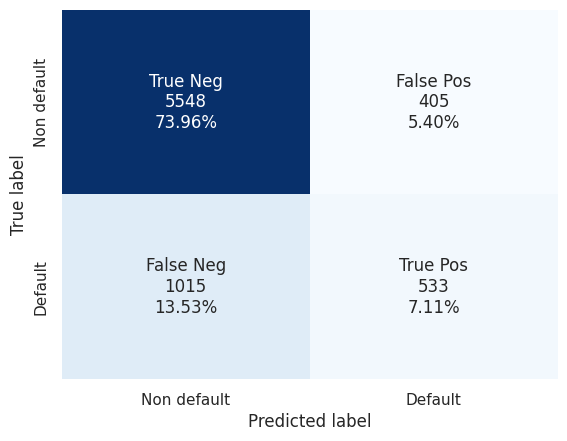

In [ ]:
import catboost as cb
params_cb ={'iterations': 50,
            'max_depth': 10
            }

model_cb = cb.CatBoostClassifier(**params_cb)
run_model(model = model_cb, df_train = df_train_woe, df_test = df_test_woe)

##LightGBM

[LightGBM] [Info] Number of positive: 5088, number of negative: 17411
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 95
[LightGBM] [Info] Number of data points in the train set: 22499, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226143 -> initscore=-1.230217
[LightGBM] [Info] Start training from score -1.230217
Accuracy = 0.8356219170777229
ROC Area under Curve = 0.7909996197604752
Precision  = 0.7069645203679369
Recall  = 0.3475452196382429
F1 Score  = 0.4660025985275011
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      5953
           1       0.71      0.35      0.47      1548

    accuracy                           0.84      7501
   macro avg       0.78      0.66      0.68      7501
weighted 

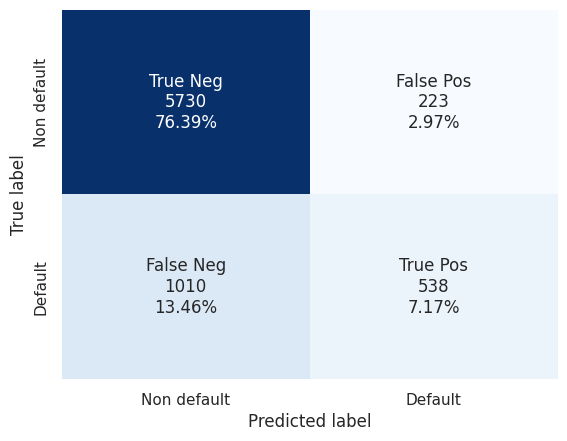

In [ ]:
import lightgbm as lgb
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,
          'max_depth': 4,
          'min_child_samples': 100,
          'max_bin': 100,
          'subsample': 0.9,
          'subsample_freq': 1,
          'colsample_bytree': 0.7
         }
model_lgb = lgb.LGBMClassifier(**params)
run_model(model = model_lgb, df_train = df_train_woe, df_test = df_test_woe)

##XGB

Accuracy = 0.823623516864418
ROC Area under Curve = 0.7587903803740844
Precision  = 0.6350540216086434
Recall  = 0.3417312661498708
F1 Score  = 0.4443511129777405
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      5953
           1       0.64      0.34      0.44      1548

    accuracy                           0.82      7501
   macro avg       0.74      0.65      0.67      7501
weighted avg       0.80      0.82      0.80      7501



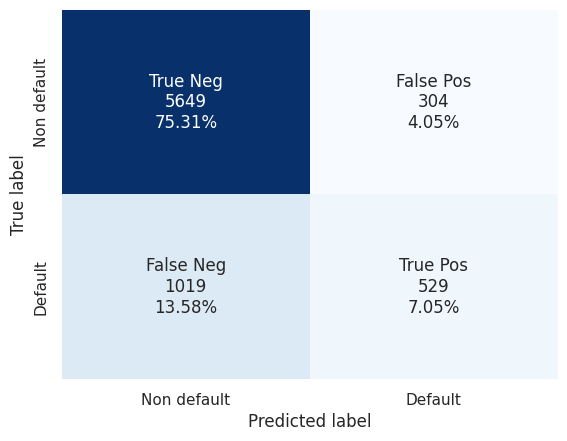

In [ ]:
import xgboost as xgb
params_xgb ={
    'booster': 'dart',
    'objective':'binary:logistic',
    'eta':0.1,
    'silent':True,
    'max_depth':8,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'eval_metric':'auc',
    'random_state': 42,
    'n_estimators': 200
    }

model_xgb = xgb.XGBClassifier(**params_xgb)
run_model(model = model_xgb, df_train = df_train_woe, df_test = df_test_woe)

Từ đó ta có bảng tổng kết hiệu suất của các mô hình

| Model  | AUC   | Type II  |  
|:---:|:---:|:---:|
| Logistic Regression | 0.7741 | 8.95  |   
| Random Forest  | 0.7512  | 11.68  |   
| AdaBoost   |  0.7769 |  **8.28** |   
| CatBoost   | 0.7282  | 13.97  |   
| LightGBM   |  **0.7803** | 13.45  |   
| XGBoost   |  0.7477 | 13.98  |   

* Với bài toán Behavior Scoring, chúng ta nên chú trọng vào việc giảm số lượng sai lầm loại II (FN) mà mô hình phán đoán được. Những khách hàng thuộc sai lầm loại II về thực tế họ đã chưa thanh toán nhưng mô hình dự đoán những khách hàng này đã thanh toán theo đúng kỳ hạn. Xét theo góc độ tín dụng, nếu KH trả lãi không đủ và đúng hạn thì điểm tín dụng của KH sẽ thấp, nhảy nhóm nợ trên hệ thống tin tín dụng quốc gia CIC, điều này sẽ gây khó khăn cho các khoản vay tiếp theo của KH vì để có một CIC đẹp là người đã từng vay và trả lãi đúng hạn nên sai lầm loại II (FN) có tính chất nghiêm trọng hơn. Do đó,  ngoài việc lựa chọn mô hình tốt, chúng ta cũng cần lựa chọn những mô hình có các TH thuộc sai lầm loại II là thấp nhất.
* Dựa vào đồ thị trên kết hợp với confusion matrix của các mô hình đã huấn luyện ở trên thì mô hình LightGBM cho AUC tốt nhất 78.03%  và mô hình AdaBoost có số lượng sai lầm loại II thấp nhất 8.28%. Ở đây chúng ta sẽ thấy mô hình Logistic Regression có AUC và Type II gần như không kém 2 mô hình trên quá nhiều mà có rất nhiều ưu điểm như mô hình rất dễ giải thích và đơn giản để có thể huấn luyện, kiểm thử, tinh chỉnh trong thời gian ngắn, do đó chọn mô hình Logistic Regression làm mô hình cuối cùng để áp dụng vào bài toán này!

# Scorecard Pipeline

In [ ]:
card = toad.ScoreCard(
    combiner = combiner,
    transer = t,
    class_weight = 'balanced',
    C=0.1,
    base_score = 1000,
    base_odds = 35 ,
    pdo = 80,
    rate = 2
)

card.fit(df_train_woe[features_list], df_train_woe['target'])

ScoreCard(base_score=1000,
          combiner=<toad.transform.Combiner object at 0x7c761057e9e0>, pdo=80,
          transer=<toad.transform.WOETransformer object at 0x7c760c167130>)

In [ ]:
filename = 'CreditScore_save5_ScoreCard.pkl'
pickle.dump(card, open(filename, 'wb'))

In [ ]:
df_test['CreditScore'] = card.predict(df_test)
df_test['CreditScore'].describe()

count    7501.000000
mean      626.896946
std       112.420376
min       166.880486
25%       598.389363
50%       659.374155
75%       700.155949
max       804.407003
Name: CreditScore, dtype: float64

In [ ]:
df['CreditScore'] = card.predict(df)
df['CreditScore'].describe()

count    30000.000000
mean       617.172826
std        117.602057
min        163.031919
25%        578.161670
50%        653.563403
75%        694.908149
max        812.041387
Name: CreditScore, dtype: float64

In [ ]:
final_card_score=card.export()
len(final_card_score)

21

In [ ]:
keys = list(card.export().keys())
score_card_df = pd.DataFrame()
for n in keys:
    temp = pd.DataFrame.from_dict(final_card_score[n], orient='index')
    temp = temp.reset_index()
    temp.columns= ['binning','score']
    temp['variable'] = n
    temp = temp[['variable','binning','score']]
    score_card_df=score_card_df.append(temp)

score_card_df.head(30)

,variable,binning,score
0,LIMIT_BAL,[-inf ~ 50000.0),-4.09
1,LIMIT_BAL,[50000.0 ~ 60000.0),18.39
2,LIMIT_BAL,[60000.0 ~ 80000.0),11.35
3,LIMIT_BAL,[80000.0 ~ 110000.0),22.82
4,LIMIT_BAL,[110000.0 ~ 150000.0),29.72
5,LIMIT_BAL,[150000.0 ~ 230000.0),41.59
6,LIMIT_BAL,[230000.0 ~ 370000.0),49.09
7,LIMIT_BAL,[370000.0 ~ inf),61.47
0,EDUCATION,[-inf ~ 2),28.49
1,EDUCATION,[2 ~ inf),27.82


Tới đây ta đã có bảng tiêu chí chấm điểm tín dụng cho từng khách hàng

In [ ]:
score_card_df.to_csv('CreditScore_save6_score_card_df.csv',index=False)

## Distribution Analysis

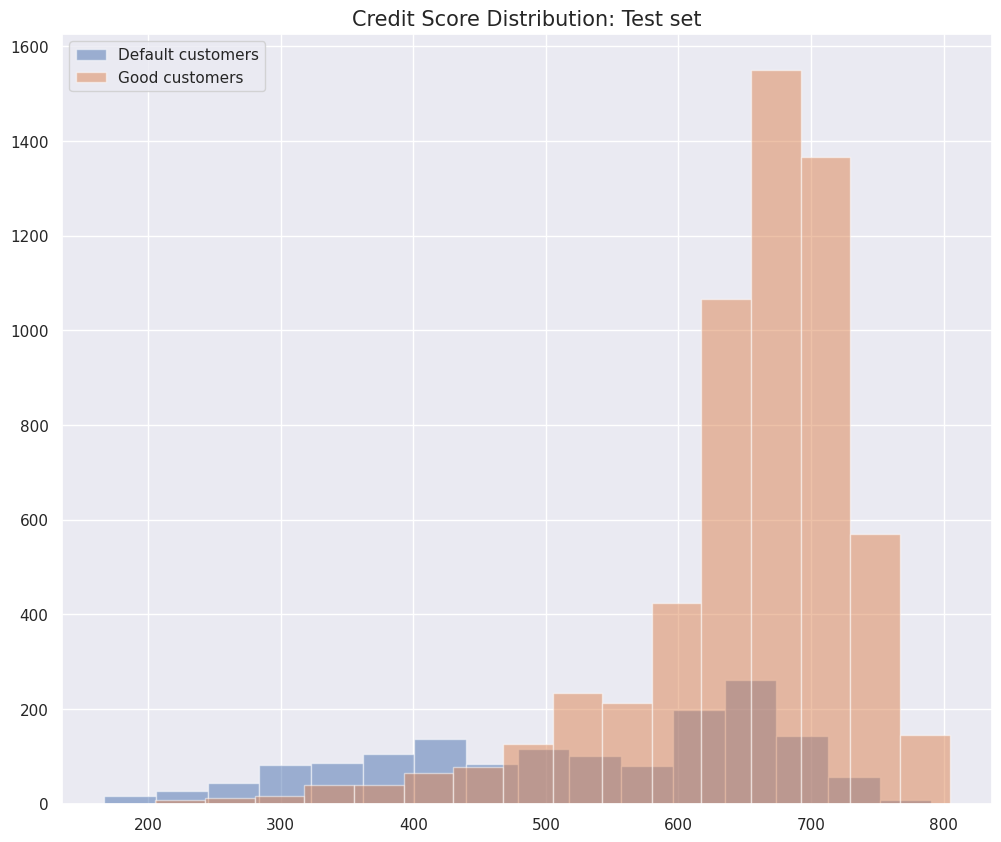

In [ ]:
plt.figure(figsize=(12,10))

w = 40
n = math.ceil((df_test['CreditScore'].max() - df_test['CreditScore'].min())/w)
#bins = numpy.linspace(-10, 10, 100)

plt.hist(df_test[df_test.target==1].CreditScore, alpha=0.5, label='Default customers',bins = n)
plt.hist(df_test[df_test.target==0].CreditScore, alpha=0.5, label='Good customers',bins = n)
plt.legend(loc='upper left')
plt.title('Credit Score Distribution: Test set',size=15)
plt.show()

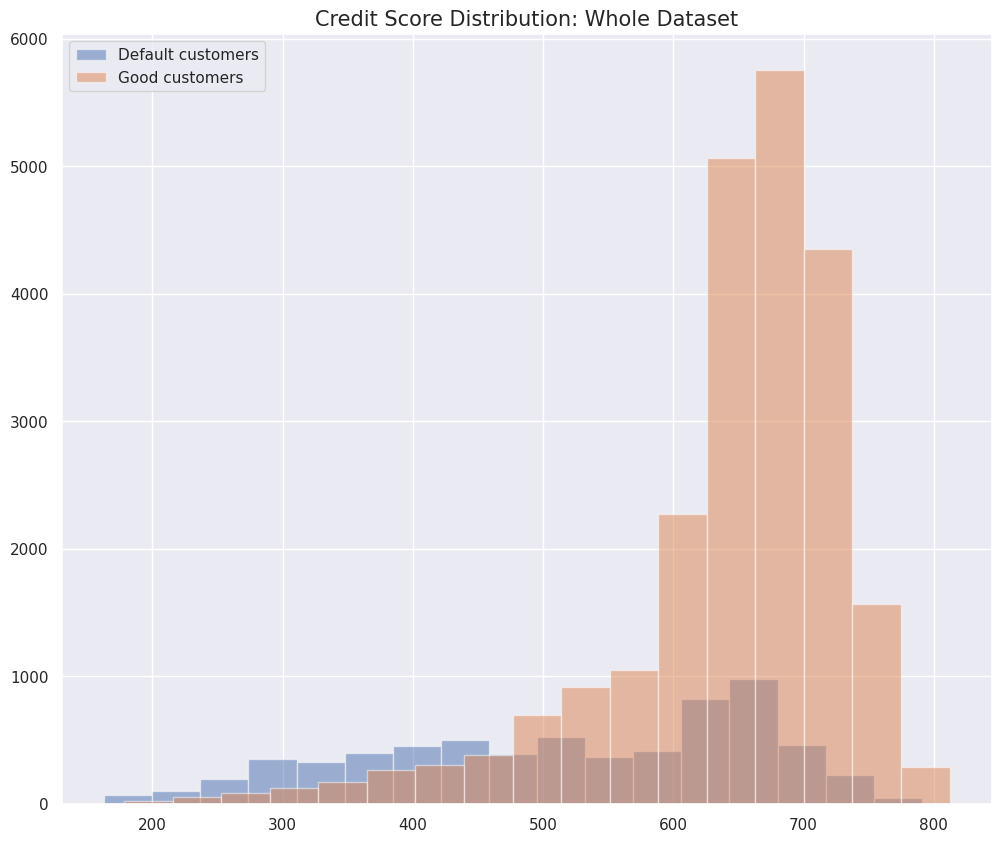

In [ ]:
plt.figure(figsize=(12,10))

import math

w = 40
n = math.ceil((df['CreditScore'].max() - df['CreditScore'].min())/w)
#bins = numpy.linspace(-10, 10, 100)

plt.hist(df[df.target==1].CreditScore, alpha=0.5, label='Default customers',bins = n)
plt.hist(df[df.target==0].CreditScore, alpha=0.5, label='Good customers',bins = n)
plt.legend(loc='upper left')
plt.title('Credit Score Distribution: Whole Dataset',size=15)
plt.show()

Đỉnh của phân phối của Good customer sẽ có xu hướng dịch về phải và Default customer sẽ dịch về trái. 2 phân phối này càng có sự phân cực rõ ràng thì scorecard phân hóa khách hàng càng hiệu quả.

## Threshold Tuning & Trade-off between loss & Coverage

Mục tiêu là chia các khách hàng thành 8 nhóm khác nhau tương đương với
 8 khoảng điểm tín dụng khác nhau, từ Blacklist đến Perfect Credt.

In [ ]:
obj_df = pd.DataFrame(
    {'Credit Level': ['Level 0', 'Level 1', 'Level 2','Level 3','Level 4','Level 5','Level 6','Level 7','Level 8'],
     'Description': ['Blacklist', 'High Risk', 'Medium Risk','Moderate Risk','Low Risk','Normal Credit','Good Credit','Excellent Credit','Prefect Credit']
     }
)

obj_df

,Credit Level,Description
0,Level 0,Blacklist
1,Level 1,High Risk
2,Level 2,Medium Risk
3,Level 3,Moderate Risk
4,Level 4,Low Risk
5,Level 5,Normal Credit
6,Level 6,Good Credit
7,Level 7,Excellent Credit
8,Level 8,Prefect Credit


Từ đây chúng ta sẽ tinh chỉnh từng khoảng điểm tín dụng cho phù hợp nhất với mỗi nhóm

In [ ]:
def get_credit_level(
    test,
    target_score ='order_score',
    out_col = 'order_level',
    left_bound = -100,
    level_0 = 100,
    level_1 = 200,
    level_2 = 250,
    level_3 = 300,
    level_4 = 350,
    level_5 = 400,
    level_6 = 450,
    level_7 = 500,
    level_8 = 800
    ):

    level = []
    for i in range(len(test)):
        if (test[target_score][i]>left_bound) & (test[target_score][i]<=level_0):
            level.append(0)
        elif  (test[target_score][i]>level_0) & (test[target_score][i]<=level_1):
            level.append(1)
        elif  (test[target_score][i]>level_1) & (test[target_score][i]<=level_2):
            level.append(2)
        elif  (test[target_score][i]>level_2) & (test[target_score][i]<=level_3):
            level.append(3)
        elif  (test[target_score][i]>level_3) & (test[target_score][i]<=level_4):
            level.append(4)
        elif  (test[target_score][i]>level_4) & (test[target_score][i]<=level_5):
            level.append(5)
        elif  (test[target_score][i]>level_5) & (test[target_score][i]<=level_6):
            level.append(6)
        elif  (test[target_score][i]>level_6) & (test[target_score][i]<=level_7):
            level.append(7)
        elif  (test[target_score][i]>level_7 )& (test[target_score][i]<=level_8):
            level.append(8)

    test[out_col] = level
    return test

In [ ]:
df_test.CreditScore.describe()

count    7501.000000
mean      626.896946
std       112.420376
min       166.880486
25%       598.389363
50%       659.374155
75%       700.155949
max       804.407003
Name: CreditScore, dtype: float64

In [ ]:
df_test = get_credit_level(df_test,
                       target_score ='CreditScore',
                       out_col = 'CreditScore_level',
                       left_bound = -1000,
                       level_0 = 250,
                       level_1 = 300,
                       level_2 = 400,
                       level_3 = 500,
                       level_4 = 580,
                       level_5 = 630,
                       level_6 = 690,
                       level_7 = 730,
                       level_8 = 850
                       )

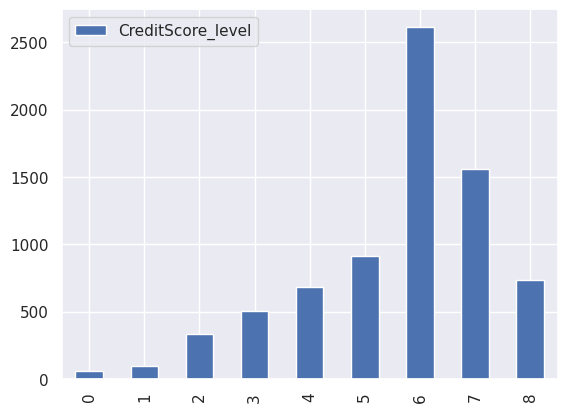

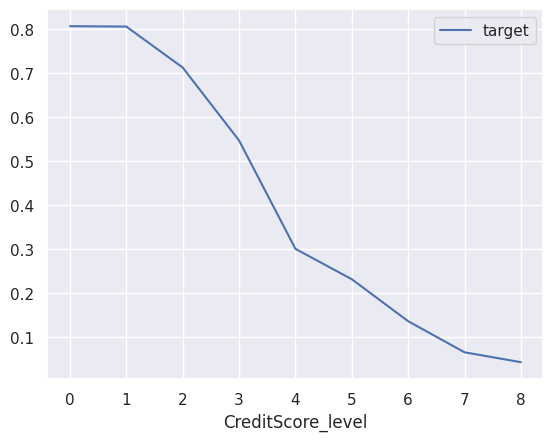

In [ ]:
def plot_bts_level_loss(test, target_col):
    bts_level_df = test[target_col].value_counts()
    bts_level_df=pd.DataFrame(bts_level_df)
    df_label_level= test[test.target==1].groupby(target_col)['target'].count()/ test.groupby(target_col)['target'].count()
    df_label_level = pd.DataFrame(df_label_level)
    bts_level_df.sort_index().plot.bar(title='')
    df_label_level.plot()

plot_bts_level_loss(df_test,target_col='CreditScore_level')

Biểu đồ 1 biểu thị số lượng quan sát của từng nhóm khách hàng, biểu đồ 2 biểu thị tỷ lệ vỡ nợ của từng nhóm

In [ ]:
def get_loss_coverage(test,target_level):

    #level 8 Loss
    L8_loss=test[test[target_level]>=8 ].target.value_counts()/len(test[test[target_level]>=8 ])
    #level 8 Coverage
    L8_coverage=test[test[target_level]>=8].target.value_counts()[0]/test[test.target==0].shape[0]
    print("Level 8: Loss is ",L8_loss[1], "; Coverage is ",L8_coverage)

    #level 7-level 8 Loss
    L7_loss=test[test[target_level]>=7 ].target.value_counts()/len(test[test[target_level]>=7 ])
    #level 7-level 8 Coverage
    L7_coverage=test[test[target_level]>=7].target.value_counts()[0]/test[test.target==0].shape[0]
    print("Level 7-Level 8: Loss is ",L7_loss[1], "; Coverage is ",L7_coverage)

    #level 6-level 8 Loss
    L6_loss=test[test[target_level]>=6 ].target.value_counts()/len(test[test[target_level]>=6 ])
    #level 6-level 8 Coverage
    L6_coverage=test[test[target_level]>=6].target.value_counts()[0]/test[test.target==0].shape[0]
    print("Level 6-Level 8: Loss is ",L6_loss[1], "; Coverage is ",L6_coverage)

     #level 5-Leve 8 Loss (percentage of default people)
    L5_loss = test[test[target_level]>=5 ].target.value_counts()/len(test[test[target_level]>=5 ])
    #level 5- level 8 Coverage (percentage of good people)
    L5_coverage=test[test[target_level]>=5 ].target.value_counts()[0]/test[test.target==0].shape[0]
    print("Level 5-Level 8: Loss is ",L5_loss[1], "; Coverage is ",L5_coverage)

    #level 4-level 8 Loss
    L4_loss=test[test[target_level]>=4 ].target.value_counts()/len(test[test[target_level]>=4 ])
    #level 4-level 8 Coverage
    L4_coverage=test[test[target_level]>=4].target.value_counts()[0]/test[test.target==0].shape[0]
    print("Level 4-Level 8: Loss is ",L4_loss[1], "; Coverage is ",L4_coverage)


    #level 3-level 8 Loss
    L3_loss=test[test[target_level]>=3].target.value_counts()/len(test[test[target_level]>=3 ])
    #level 3-level 8 Coverage
    L3_coverage=test[test[target_level]>=3].target.value_counts()[0]/test[test.target==0].shape[0]
    print("Level 3-Level 8: Loss is ",L3_loss[1], "; Coverage is ",L3_coverage)

    #level 2-level 8 Loss
    L2_loss=test[test[target_level]>=2].target.value_counts()/len(test[test[target_level]>=2 ])
    #level 2-level 8 Coverage
    L2_coverage=test[test[target_level]>=2].target.value_counts()[0]/test[test.target==0].shape[0]
    print("Level 2-Level 8: Loss is ",L2_loss[1], "; Coverage is ",L2_coverage)

    #level 1-level 8 Loss
    L1_loss=test[test[target_level]>=1].target.value_counts()/len(test[test[target_level]>=1 ])
    #level 1-level 8 Coverage
    L1_coverage=test[test[target_level]>=1].target.value_counts()[0]/test[test.target==0].shape[0]
    print("Level 1-Level 8: Loss is ",L1_loss[1], "; Coverage is ",L1_coverage)

    #level 0-level 8 Loss
    L0_loss=test[test[target_level]>=0].target.value_counts()/len(test[test[target_level]>=0 ])
    #level 0-level 8 Coverage
    L0_coverage=test[test[target_level]>=0].target.value_counts()[0]/test[test.target==0].shape[0]
    print("Level 0-Level 8: Loss is ",L0_loss[1], "; Coverage is ",L0_coverage)

In [ ]:
get_loss_coverage(df_test,target_level='CreditScore_level')

Level 8: Loss is  0.043478260869565216 ; Coverage is  0.11825970099109692
Level 7-Level 8: Loss is  0.0587467362924282 ; Coverage is  0.3633462119939526
Level 6-Level 8: Loss is  0.1001628664495114 ; Coverage is  0.7424827817906937
Level 5-Level 8: Loss is  0.12083762444215586 ; Coverage is  0.8604065177221569
Level 4-Level 8: Loss is  0.1396957123098202 ; Coverage is  0.9403662019150009
Level 3-Level 8: Loss is  0.16920883820384888 ; Coverage is  0.9790021837728876
Level 2-Level 8: Loss is  0.19371086305472365 ; Coverage is  0.9949605241054931
Level 1-Level 8: Loss is  0.2017732401934444 ; Coverage is  0.9981521921720141
Level 0-Level 8: Loss is  0.20637248366884414 ; Coverage is  1.0


In [ ]:
obj_df = pd.DataFrame(
    {'Credit Level': ['Level 0', 'Level 1', 'Level 2','Level 3','Level 4','Level 5','Level 6','Level 7','Level 8'],
     'Description': ['Blacklist', 'High Risk', 'Medium Risk','Moderate Risk','Low Risk','Normal Credit','Good Credit','Excellent Credit','Prefect Credit'],
     'Scores Range': ['0-250', '250-300', '300-400', '400-500', '500-580', '580-630', '630-690', '690-730', '730-800']
     }
)

obj_df

,Credit Level,Description,Scores Range
0,Level 0,Blacklist,0-250
1,Level 1,High Risk,250-300
2,Level 2,Medium Risk,300-400
3,Level 3,Moderate Risk,400-500
4,Level 4,Low Risk,500-580
5,Level 5,Normal Credit,580-630
6,Level 6,Good Credit,630-690
7,Level 7,Excellent Credit,690-730
8,Level 8,Prefect Credit,730-800


In [ ]:
obj_df['Customers'] = df_test['CreditScore_level'].value_counts().sort_index().tolist()
obj_df['Customer Rate'] = (df_test['CreditScore_level'].value_counts().sort_index() / len(df_test) * 100).tolist()
obj_df['Good Customers'] = df_test[df_test.target == 0]['CreditScore_level'].value_counts().sort_index().tolist()
obj_df['Default Customers'] = df_test[df_test.target == 1]['CreditScore_level'].value_counts().sort_index().tolist()
obj_df['Default Rate'] = (df_test[df_test.target == 1]['CreditScore_level'].value_counts().sort_index().div(obj_df['Customers']) * 100).tolist()

In [ ]:
obj_df.style.bar()

,Credit Level,Description,Scores Range,Customers,Customer Rate,Good Customers,Default Customers,Default Rate
0,Level 0,Blacklist,0-250,57,0.759899,11,46,80.701754
1,Level 1,High Risk,250-300,98,1.306492,19,79,80.612245
2,Level 2,Medium Risk,300-400,331,4.412745,95,236,71.299094
3,Level 3,Moderate Risk,400-500,508,6.772430,230,278,54.724409
4,Level 4,Low Risk,500-580,681,9.078789,476,205,30.102790
5,Level 5,Normal Credit,580-630,914,12.185042,702,212,23.194748
6,Level 6,Good Credit,630-690,2614,34.848687,2257,357,13.657230
7,Level 7,Excellent Credit,690-730,1562,20.823890,1459,103,6.594110
8,Level 8,Prefect Credit,730-800,736,9.812025,704,32,4.347826


In [ ]:
print('Total customer:' , len(df_test))
print('Total default customer:' , df_test[df_test.target == 1].target.sum())

Total customer: 7501
Total default customer: 1548


Từ bảng tổng kết trên có thể thấy:

- Nếu cho toàn bộ khách hàng vay tiền (từ bậc 0 đến 8) thì tỷ lệ sai sót là **tổng khách hàng vợ nợ / tổng khách hàng (1548/7501) ~ 21%**


- Giả sử sếp yêu cầu có thể cho **tối đa 70% khách hàng nộp hồ sơ được vay tiền và chấp nhận một chút rủi ro là khoảng 10%** thì nên cho các **khách hàng từ bậc 6 trở lên** do tỷ lệ sai sót là
(357 + 103 + 32)/(2614 + 1562 + 736) = 10.01% với số lượng khách hàng được vay là (2614 + 1562 + 736)/ (tổng khách hàng nộp hồ sơ) là 65.48%

## Inference Pipeline

Chọn 1 khách hàng trong tập test

In [ ]:
df_test.loc[0,:]

ID                    22500.000000
LIMIT_BAL            420000.000000
SEX                       2.000000
EDUCATION                 2.000000
MARRIAGE                  1.000000
AGE                      37.000000
PAY_0                     0.000000
PAY_2                     0.000000
PAY_3                     0.000000
PAY_4                     0.000000
PAY_5                     0.000000
PAY_6                     0.000000
BILL_AMT1             36032.000000
BILL_AMT2             41932.000000
BILL_AMT3              9778.000000
BILL_AMT4            158901.000000
BILL_AMT5            161876.000000
BILL_AMT6            165378.000000
PAY_AMT1               7022.000000
PAY_AMT2               1846.000000
PAY_AMT3             163862.000000
PAY_AMT4               6000.000000
PAY_AMT5               6000.000000
PAY_AMT6               6000.000000
target                    0.000000
CreditScore             745.026339
CreditScore_level         8.000000
Name: 0, dtype: float64

In [ ]:
card.predict(df_test)[0]

745.0263390798293

Theo phân loại trên thì khách hàng này thuộc bậc 8 (Perfect Credit). Khách hàng xứng đáng được cho vay.

# Conclusion & Future works

- Sử dụng thêm deep learning model như neural network, TabNet, NODE,... và khai thác thêm nhiều biến để cải thiện hiệu suất dự đoán và giúp tăng false positive rate để khách hàng hài lòng hơn